# Imports

In [1]:
# Our tools
import exoplanet as xo
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import lightkurve as lk
from astropy.io import fits
from astropy.timeseries import BoxLeastSquares
from scipy import stats
import graphviz
import astropy.units as u

import pymc3 as pm
import aesara_theano_fallback.tensor as tt
import pymc3_ext as pmx
from functools import partial

import os
import warnings
#os.environ["MKL_THREADING_LAYER"] = "GNU"
#warnings.filterwarnings("ignore", category=DeprecationWarning)
#warnings.filterwarnings("ignore", category=FutureWarning)

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline
plt.style.use('seaborn-dark-palette')

/tmp/ipykernel_195097/1667230561.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-dark-palette')


In [3]:
plt.rcParams["figure.figsize"]=8,6
plt.rcParams.update({'font.size': 16})

# Data

## Tess

In [4]:
#sectors times, 15-22-23-48-50
from astropy.time import Time
sectors = ['2019-08-15T20:45:00','2019-09-10T22:00:00','2020-02-19T19:20:00','2020-03-18T00:00:00',
'2020-03-19T14:30:00','2020-04-15T09:10:00','2022-01-28T10:25:00','2022-02-25T11:50:00','2022-03-26T18:30:00','2022-04-22T00:25:00']
sectors_times = Time(sectors, format='fits')
sectors_times_btjd = sectors_times.jd-2457000
sectors_times_btjd

array([1711.36458333, 1737.41666667, 1899.30555556, 1926.5       ,
       1928.10416667, 1954.88194444, 2607.93402778, 2635.99305556,
       2665.27083333, 2691.51736111])

In [5]:
lk.search_lightcurve('TIC 445859771')

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 15,2019,SPOC,120,445859771,0.0
1,TESS Sector 15,2019,TESS-SPOC,1800,445859771,0.0
2,TESS Sector 15,2019,QLP,1800,445859771,0.0
3,TESS Sector 15,2019,TASOC,120,445859771,0.0
4,TESS Sector 15,2019,TASOC,1800,445859771,0.0
5,TESS Sector 15,2019,TASOC,1800,445859771,0.0
6,TESS Sector 16,2019,TESS-SPOC,1800,445859771,0.0
7,TESS Sector 16,2019,QLP,1800,445859771,0.0
8,TESS Sector 22,2020,SPOC,120,445859771,0.0


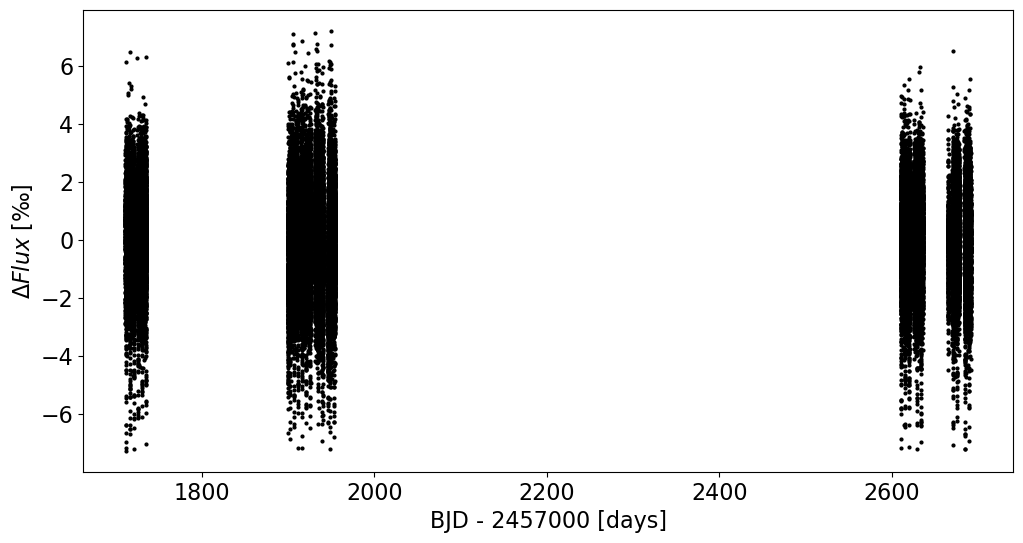

In [6]:
lc_file = lk.search_lightcurve('TIC 445859771', author='SPOC').download_all(flux_column="pdcsap_flux")
lc = lc_file.stitch().remove_nans().normalize().remove_outliers()
time = lc.time.value
flux = lc.flux

with fits.open(lc_file[0].filename) as hdu:
    hdr = hdu[1].header

texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

ref_time = 0.5 * (np.min(time) + np.max(time))
x_ = np.ascontiguousarray(time - ref_time, dtype=np.float64)
y_ = np.ascontiguousarray(1e3 * (flux - 1.0), dtype=np.float64) # Here we convert flux to ppt
yerr_ = np.ascontiguousarray(1e3 * lc.flux_err, dtype=np.float64)

plt.figure(figsize=(12, 6))
plt.plot(time, y_, "o", color='black',markersize=2)
#plt.errorbar(time, (flux-1.0)*1e3, yerr=lc.flux_err*1e3, color='k', fmt='o', ms=2)
plt.xlabel("BJD - 2457000 [days]")
plt.ylabel(u'$\Delta Flux$ [‰]')
plt.show()
#plt.savefig('tessdata_1199.png',dpi=300,bbox_inches='tight')

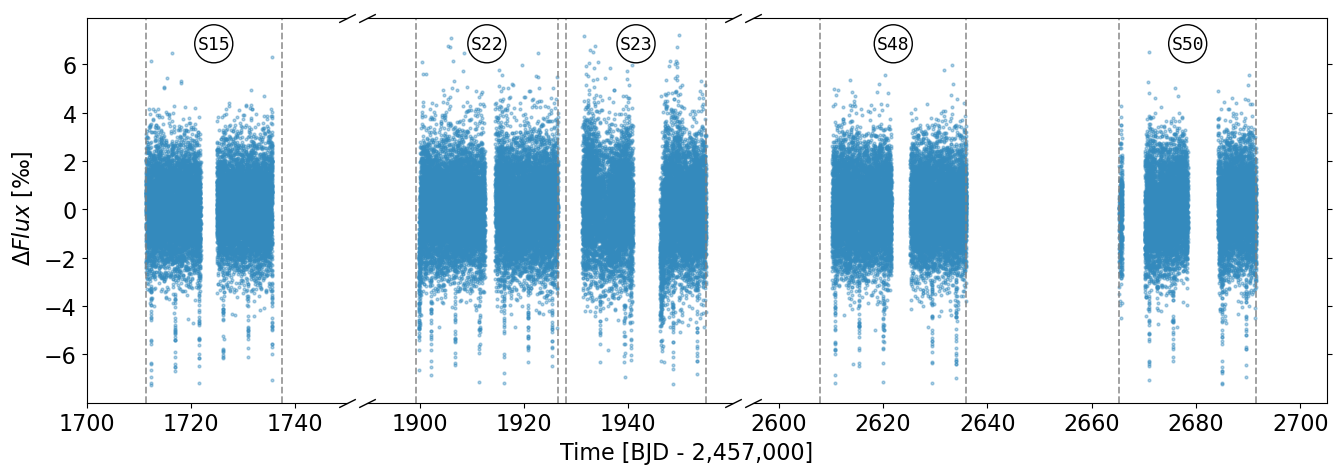

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=True, figsize=(16,5), gridspec_kw={'width_ratios': [1, 1.4, 2.2]})
fig.subplots_adjust(wspace=0.05)
ax1.plot(time, y_, "o", color='#348ABD', markersize=2, alpha=0.4)
ax2.plot(time, y_, "o", color='#348ABD', markersize=2, alpha=0.4)
ax3.plot(time, y_, "o", color='#348ABD', markersize=2, alpha=0.4)
off=15
ax1.set_xlim(1700, 1750)  
ax2.set_xlim(1890, 1960)  
ax3.set_xlim(2595, 2705)  
ax2.set_xticks([1900, 1920, 1940])
ax1.spines.right.set_visible(False)
ax2.spines.right.set_visible(False)
ax2.spines.left.set_visible(False)
ax3.spines.left.set_visible(False)
ax1.yaxis.tick_left()
#ax2.set_yticks([])
ax2.yaxis.tick_right()
ax3.yaxis.tick_right()
ax1.tick_params(labelright=False)
ax2.tick_params(axis='y', which='both', left=False, right=False, labelright=False)
ax2.tick_params(labelleft=False)
ax3.tick_params(labelleft=False)

d = .5  
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12, linestyle="none", color='k', mec='k', mew=1, clip_on=False)

ax1.plot([1, 1], [0, 1], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 0], [1, 0], transform=ax2.transAxes, **kwargs)
ax2.plot([1, 1], [0, 1], transform=ax2.transAxes, **kwargs)
ax3.plot([0, 0], [1, 0], transform=ax3.transAxes, **kwargs)
for i in sectors_times_btjd[:2]:
    ax1.axvline(x=i, color='gray', linestyle='--', linewidth=1.3, alpha=0.8)
for i in sectors_times_btjd[2:6]:
    ax2.axvline(x=i, color='gray', linestyle='--', linewidth=1.3, alpha=0.8)
for i in sectors_times_btjd[6:]:
    ax3.axvline(x=i, color='gray', linestyle='--', linewidth=1.3, alpha=0.8)
ax1.text(sectors_times_btjd[0]+(sectors_times_btjd[1]-sectors_times_btjd[0])/2, 6.85, 
    "S15", ha="center", va="center", size=13, fontfamily='monospace',
    bbox=dict(boxstyle="circle,pad=0.15", fc='white', lw=1))
ax2.text(sectors_times_btjd[2]+(sectors_times_btjd[3]-sectors_times_btjd[2])/2, 6.85, 
    "S22", ha="center", va="center", size=13, fontfamily='monospace',
    bbox=dict(boxstyle="circle,pad=0.15", fc='white', lw=1))
ax2.text(sectors_times_btjd[4]+(sectors_times_btjd[5]-sectors_times_btjd[4])/2, 6.85, 
    "S23", ha="center", va="center", size=13, fontfamily='monospace',
    bbox=dict(boxstyle="circle,pad=0.15", fc='white', lw=1))
ax3.text(sectors_times_btjd[6]+(sectors_times_btjd[7]-sectors_times_btjd[6])/2, 6.85, 
    "S48", ha="center", va="center", size=13, fontfamily='monospace',
    bbox=dict(boxstyle="circle,pad=0.15", fc='white', lw=1))
ax3.text(sectors_times_btjd[8]+(sectors_times_btjd[9]-sectors_times_btjd[8])/2, 6.85, 
    "S50", ha="center", va="center", size=13, fontfamily='monospace',
    bbox=dict(boxstyle="circle,pad=0.15", fc='white', lw=1))

fig.text(0.5, 0.01, "Time [BJD - 2,457,000]", ha='center', va='center')
fig.text(0.085, 0.5, u'$\Delta Flux$ [‰]', ha='center', va='center', rotation='vertical')
#plt.savefig('tessdata_1273.png',dpi=300,bbox_inches='tight', facecolor='white')
plt.show()

BLS

In [8]:
period_grid = np.exp(np.linspace(np.log(2), np.log(8), 30000)) #2 y 8 ---- 1 y 30
durations = np.exp(np.linspace(np.log(0.01), np.log(0.2), 100)) #0.01 y 0.2 

bls = BoxLeastSquares(x_, y_, yerr_)
bls_power = bls.power(period_grid, durations, oversample=30)

# Save the highest peak as the planet candidate
index = np.argmax(bls_power.power)
bls_period = bls_power.period[index]
bls_t0 = bls_power.transit_time[index]
bls_depth = bls_power.depth[index]
bls_duration = bls_power.duration[index]

print('bls period:',bls_period)
print('bls t0:',bls_t0)
print('bls depth:',bls_depth)
print('ref_time:', ref_time)
print('epoch:', bls_t0 + ref_time)
print('bls duration:', bls_duration)

bls period: 4.631374375019575
bls t0: -489.0987763358155
bls depth: 3.6049340566184895
ref_time: 2201.436872421974
epoch: 1712.3380960861584
bls duration: 0.05266666666666668


In [9]:
# 1 y 30 grid
# bls period: 4.631191916352005
# bls t0: -489.0772763358155
# bls depth: 3.6220594837807694
# ref_time: 2201.436872421974
# epoch: 1712.3595960861585
# bls duration: 0.04833333333333336

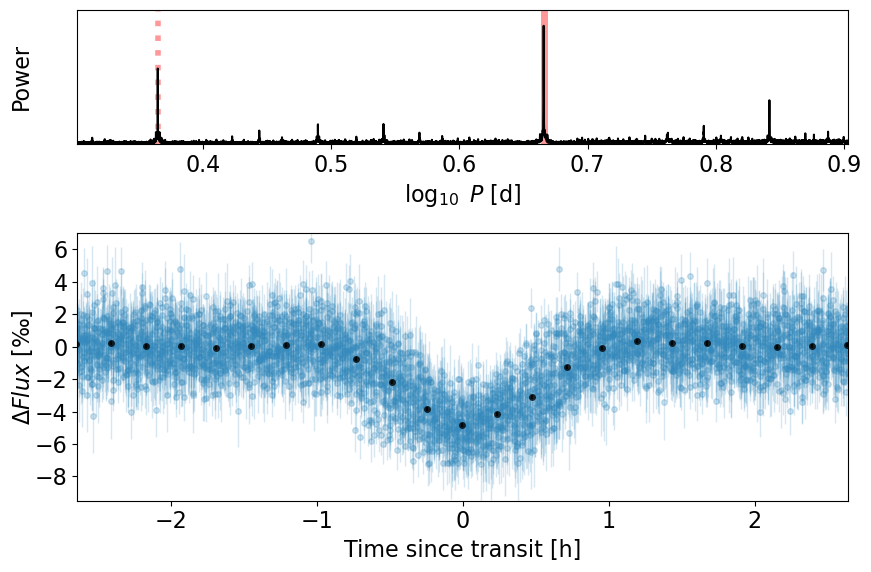

In [10]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 6), gridspec_kw={'height_ratios': [1, 2]})
fig.subplots_adjust(hspace=0.35)

ax1.axvline(np.log10(bls_period), color='red', lw=5, alpha=0.4)
ax1.axvline(np.log10(bls_period/2), linestyle='dotted', color='red', lw=4, alpha=0.4)
ax1.axvline(np.log10(bls_period/3), linestyle='dotted', color='red', lw=4, alpha=0.4)
ax1.axvline(np.log10(bls_period/4), linestyle='dotted', color="red", lw=4, alpha=0.4)
ax1.axvline(np.log10(bls_period*2), linestyle='dotted', color="red", lw=4, alpha=0.4)
ax1.axvline(np.log10(bls_period*3), linestyle='dotted', color="red", lw=4, alpha=0.4)
ax1.axvline(np.log10(bls_period*4), linestyle='dotted', color="red", lw=4, alpha=0.4)
ax1.plot(np.log10(bls_power.period), bls_power.power, color="k")
ax1.set_ylim(0,3000)
ax1.set_ylabel("Power", labelpad=32)
ax1.set_yticks([])
ax1.set_xlim(np.log10(period_grid.min())+0.001, np.log10(period_grid.max()))
ax1.set_xlabel(r"$\log_{10}~ P$ [d]")

# Plot the folded transit
x_fold_ = (x_ - bls_t0 + 0.5 * bls_period) % bls_period - 0.5 * bls_period
m = np.abs(x_fold_) < 0.4
ax2.plot(x_fold_*24, y_, ".", alpha=0.25, ms=8, color='#348ABD')
ax2.errorbar(x_fold_*24, y_, yerr=yerr_, color='#348ABD', fmt="none", capsize=0, elinewidth=1, zorder=-1000, alpha=0.2)

# Overplot the phase binned light curve
lcc = lk.LightCurve(time=x_fold_, flux=y_, flux_err=yerr_)
lcc_binned = lcc.bin(time_bin_size=0.01)
ax2.errorbar(lcc_binned['time'].value*24, lcc_binned['flux'].value, yerr=lcc_binned['flux_err'].value, fmt='o', color='k', 
                ms=5, markeredgecolor='k', markerfacecolor='k', markeredgewidth=0, capsize=2, alpha=0.8)
ax2.set_xlim(-0.11*24, 0.11*24)
ax2.set_ylim(-9.5, 7)
ax2.set_yticks([-8,-6,-4,-2,0,2,4,6])
ax2.set_ylabel(u'$\Delta Flux$ [‰]', labelpad=0)
_ = ax2.set_xlabel("Time since transit [h]")
plt.tight_layout()

#plt.savefig('bls_paper_1273.png',dpi=300,bbox_inches='tight', facecolor='white')

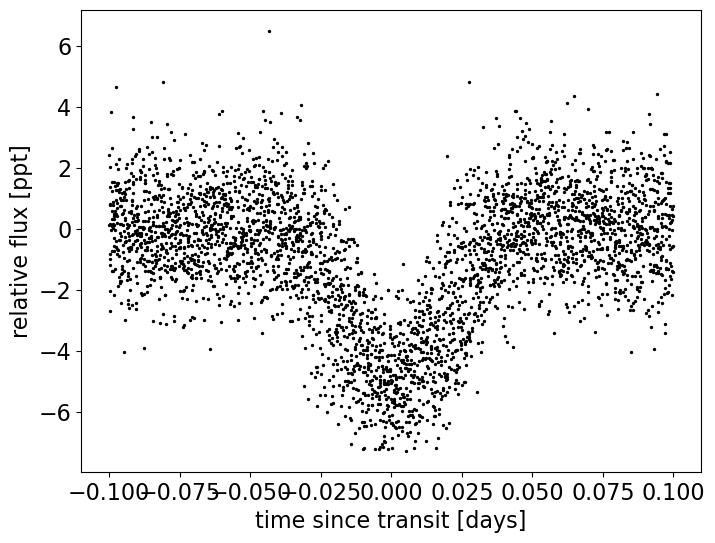

In [11]:
transit_mask = bls.transit_mask(x_, bls_period, 0.2, bls_t0)
x_fold_ = (x_ - bls_t0 + 0.5*bls_period) % bls_period - 0.5*bls_period

# Me quedo solo con los puntos cerca de los transitos
x_fold = x_fold_[transit_mask]
x = x_[transit_mask]
y = y_[transit_mask]
yerr = yerr_[transit_mask]

plt.scatter(x_fold, y, c='k', s=2)
plt.xlabel("time since transit [days]")
plt.ylabel("relative flux [ppt]");
#plt.xlim(-0.12,0.12)

## SOPHIE RVs

60


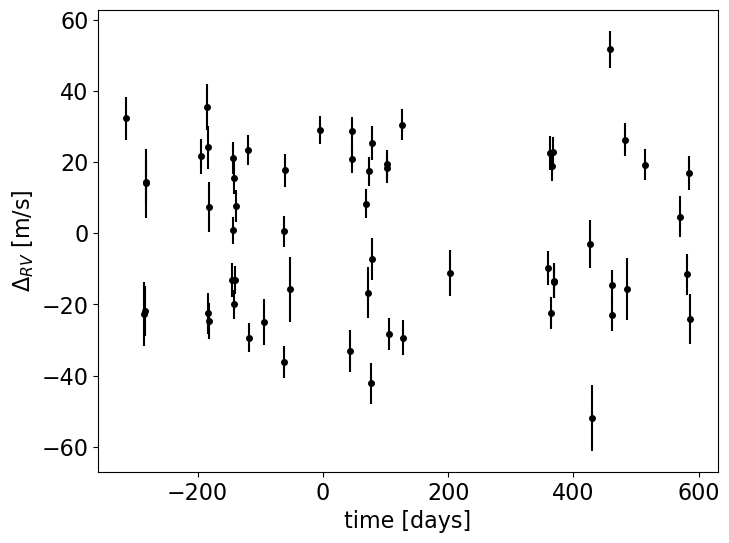

In [12]:
data = pd.read_table('./data/rvs/1273_final_rvs.dat', sep='\s+')
data.rename(columns={'rv(km/s)': 'rv', 'sigRV(km/s)':'err', 'bis(km/s)': 'bis'}, inplace=True)

x_rv = np.array(data.bjd+2400000-2457000)-ref_time
y_rv = np.array((data.rv-data.rv.mean())*1000)
yerr_rv = np.array(data.err*1000)

plt.errorbar(x_rv, y_rv, yerr=yerr_rv, fmt=".k", markersize=8)
plt.xlabel("time [days]")
print(len(x_rv))
_ = plt.ylabel("$\Delta_{RV}$ [m/s]")

In [13]:
# Compute a reference time that will be used to normalize the trends model
x_ref = 0.5 * (x_rv.min() + x_rv.max())

# Stellar parameters from Sousa
M_star = 0.98, 0.02
R_star = 1.07, 0.03

K = xo.estimate_semi_amplitude(bls_period, x_rv, y_rv, yerr_rv, t0s=bls_t0)
print('K=', K, "m/s")

msini = xo.estimate_minimum_mass(bls_period, x_rv, y_rv, yerr_rv, t0s=bls_t0, m_star=M_star[0])
msini = msini.to(u.M_earth)
print('minimum mass=', msini)

K= [26.47708999] m/s
minimum mass= [68.09246812] earthMass


Periodograms

In [14]:
from astropy.timeseries import LombScargle

In [15]:
# read de BIS data
ls = LombScargle(data.bjd, data.rv, data.err)
ls_bis = LombScargle(data.bjd, data.bis)

frequency, power = ls.autopower(minimum_frequency=0.001, maximum_frequency=2, samples_per_peak=5)

frequency_bis, power_bis = ls_bis.autopower(minimum_frequency=0.001, maximum_frequency=2, samples_per_peak=5)

probabilities = [0.1, 0.05, 0.01]
faps = ls.false_alarm_level(probabilities)  
faps_bis = ls_bis.false_alarm_level(probabilities)

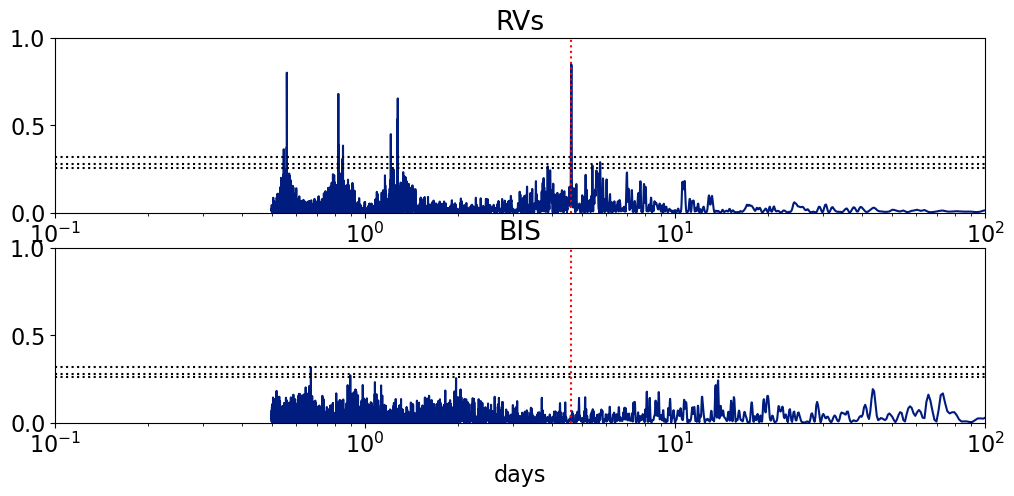

In [16]:
# plot two figures in a column
fig, axes = plt.subplots(2, 1, sharex=False, figsize=(12, 5))
axes[0].plot(1/frequency, power, label='RVs') 
axes[1].plot(1/frequency_bis, power_bis, label='BIS') 

axes[0].set_xlabel('days')
axes[0].set_xlim(0.1, 100)
axes[0].set_ylim(0, 1.0)
axes[1].set_xlabel('days')
axes[1].set_xlim(0.1, 100)
axes[1].set_ylim(0, 1.0)

axes[0].set_xscale('log')
axes[1].set_xscale('log')
axes[0].title.set_text('RVs')
axes[1].title.set_text('BIS')

# overplot the false alarm probabilities
for i, prob in enumerate(probabilities):
    axes[0].axhline(faps[i], ls=':', color='black', label='{}%'.format(prob))
    axes[1].axhline(faps_bis[i], ls=':', color='black', label='{}%'.format(prob))

# plot the 'bls_period' as a vertical line behind the plot
axes[0].axvline(bls_period, ls=':', color='red', label='bls period')
axes[1].axvline(bls_period, ls=':', color='red', label='bls period')

BIS vs rvs

Text(0, 0.5, '$\\Delta$BIS [m/s]')

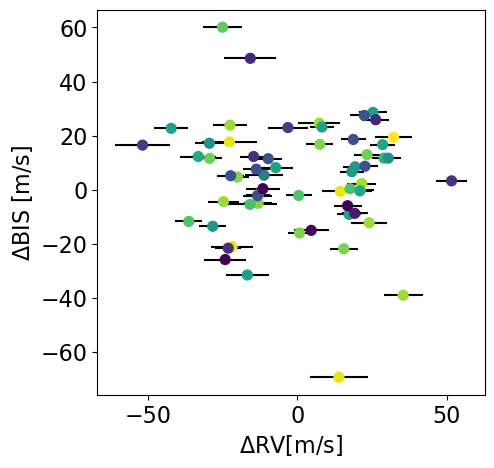

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.scatter(y_rv, data.bis*1e3, c=data.bjd, cmap='viridis_r', s=50, zorder=10)
# add errorbars on data.rv
ax.errorbar(y_rv, data.bis*1e3, xerr=yerr_rv, fmt='none', ecolor='k', markersize=8, zorder=-10)

ax.set_xlabel("$\Delta$RV[m/s]")
ax.set_ylabel("$\Delta$BIS [m/s]")

## Ground LCs

### Keplercam

In [24]:
# all have the same columns
data1 = pd.read_table('./data/photom/TOI1273/TIC445859771.01_UT2020.0213_KeplerCam_B.txt', sep='\s+')

In [106]:
#puntos?
print('puntos:', len(data1))
# texp?
texp_keplercam = None

puntos: 135


In [107]:
data1['flux'] = ((data1['rel_flux_T1']/(data1['rel_flux_T1'].median())))*1e3
data1['time'] = data1['BJD_TDB']-2457000-ref_time
data1['flux_err'] = ((data1['rel_flux_err_T1']/(data1['rel_flux_T1'].median())))*1e3

Text(0.5, 1.0, 'TOI1273')

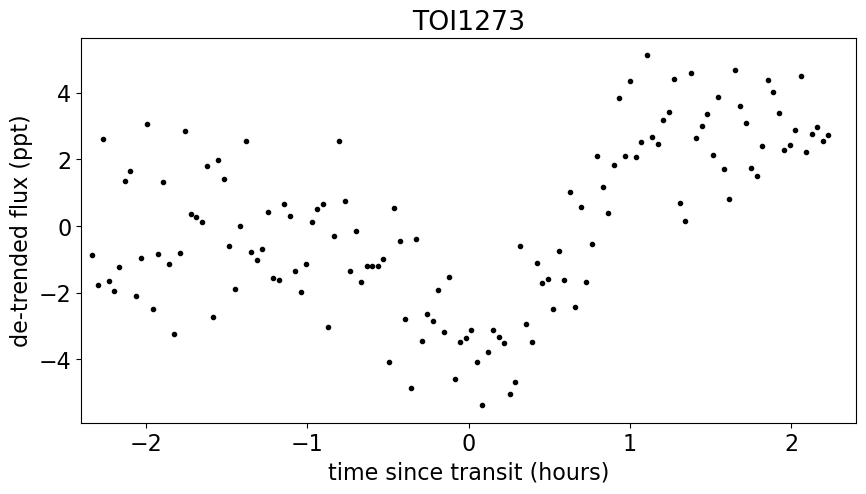

In [108]:
# Plot the folded data, con los parametros del BLS
data1_fold = (data1['time'] - bls_t0 + 0.5 * bls_period) % bls_period - 0.5 * bls_period
plt.figure(figsize=(10, 5))
plt.plot(data1_fold*24, data1['flux']-1e3, ".k", label="data1", zorder=-1000)
plt.ylabel("de-trended flux (ppt)")
plt.xlabel('time since transit (hours)')
plt.xlim(-0.10*24, 0.10*24)
plt.title("TOI1273")

In [109]:
# ajustemos un pol grado 2 a los datos oot
# mascaras para sacar los datos en transito
oot_mask1 = bls.transit_mask(data1['time'], bls_period, bls_duration, bls_t0)
x_oot_B = (data1_fold*24)[~oot_mask1]
y_oot_B = data1['flux'][~oot_mask1]
z_B = np.polyfit(x_oot_B, y_oot_B, 2)
def pol_B(x):
    return np.asarray(z_B[0]*x**2 + z_B[1]*x + z_B[2])

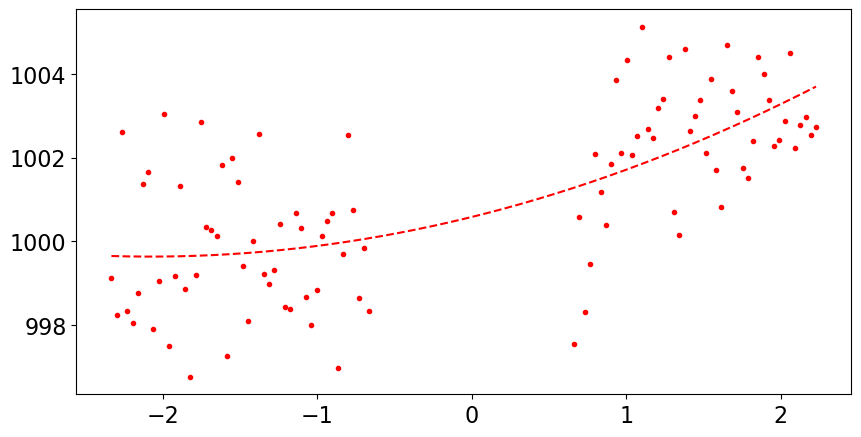

In [110]:
plt.figure(figsize=(10, 5))
plt.plot((data1_fold*24)[~oot_mask1], data1['flux'][~oot_mask1], ".r", label="data1", zorder=-1000)
x_plot_B = np.linspace(np.min(x_oot_B), np.max(x_oot_B), 1000)
plt.plot(x_plot_B, pol_B(x_plot_B), color="r", linestyle="--")


In [111]:
x_conc_B = data1_fold*24
y_conc_B = (data1['flux']/pol_B(data1_fold*24)-1)*1e3
yerr_conc_B = data1['flux_err']

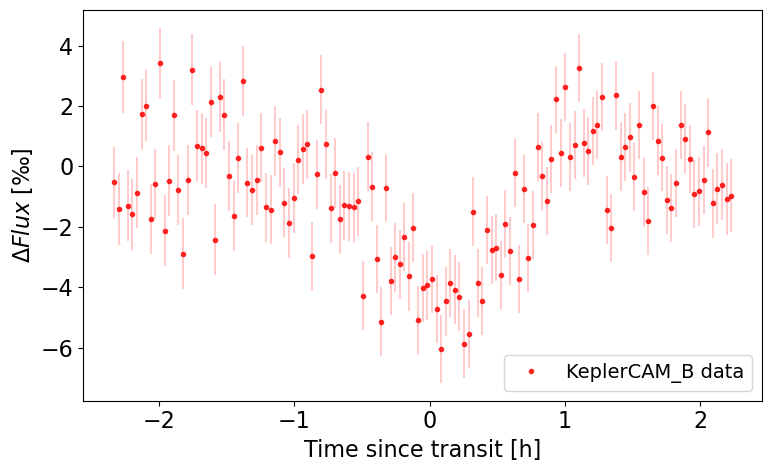

In [112]:
#replot dividing by polynomial
plt.figure(figsize=(8, 5))
# Plot the data
plt.plot(x_conc_B, y_conc_B, 'o', ms=3, color='r', 
         label='KeplerCAM_B data', zorder=1000, alpha=0.8)
plt.errorbar(x_conc_B, y_conc_B, yerr=yerr_conc_B, 
             fmt="none", color='r', capsize=0, zorder=-1000, alpha=0.2)
plt.legend(fontsize=14, loc=4)
plt.ylabel(u'$\Delta Flux$ [‰]')
plt.xlabel("Time since transit [h]")
plt.tight_layout()
#plt.savefig('new_phot_1199_keplercam.png',dpi=300,bbox_inches='tight', facecolor='white')
plt.show()

In [113]:
# datos de keplercam finales
x_keplercam_B = data1['time']
y_keplercam_B = y_conc_B
yerr_keplercam_B = yerr_conc_B

### Muscat

In [114]:
data2 = pd.read_table('./data/photom/TOI1273/TOI1273-01_20200218_zs_TCS_MuSCAT2_Detrended.dat', names=['BJD_TDB', 'flux', 'flux_err'], sep='\s+')
data3 = pd.read_table('./data/photom/TOI1273/TOI1273-01_20200218_g_TCS_MuSCAT2_Detrended.dat', names=['BJD_TDB', 'flux', 'flux_err'], sep='\s+')
data4 = pd.read_table('./data/photom/TOI1273/TOI1273-01_20200218_i_TCS_MuSCAT2_Detrended.dat', names=['BJD_TDB', 'flux', 'flux_err'], sep='\s+')
data5 = pd.read_table('./data/photom/TOI1273/TOI1273-01_20200218_r_TCS_MuSCAT2_Detrended.dat', names=['BJD_TDB', 'flux', 'flux_err'], sep='\s+')
# Convert time to the same reference time as tess and flux to ppt
data2['bjd'] = data2['BJD_TDB']-2457000-ref_time
data3['bjd'] = data3['BJD_TDB']-2457000-ref_time
data4['bjd'] = data4['BJD_TDB']-2457000-ref_time
data5['bjd'] = data5['BJD_TDB']-2457000-ref_time

data2['flux'] = np.ascontiguousarray(1e3 * (data2['flux'] - 1.0), dtype=np.float64) 
data3['flux'] = np.ascontiguousarray(1e3 * (data3['flux'] - 1.0), dtype=np.float64) 
data4['flux'] = np.ascontiguousarray(1e3 * (data4['flux'] - 1.0), dtype=np.float64) 
data5['flux'] = np.ascontiguousarray(1e3 * (data5['flux'] - 1.0), dtype=np.float64) 

data2['flux_err'] = np.ascontiguousarray(1e3 * (data2['flux_err']), dtype=np.float64) 
data3['flux_err'] = np.ascontiguousarray(1e3 * (data3['flux_err']), dtype=np.float64) 
data4['flux_err'] = np.ascontiguousarray(1e3 * (data4['flux_err']), dtype=np.float64) 
data5['flux_err'] = np.ascontiguousarray(1e3 * (data5['flux_err']), dtype=np.float64) 

In [115]:
print(len(data2), len(data3), len(data4), len(data5))

1772 1771 1772 1770


In [116]:
# Texp?
print(np.median(np.diff(data2['bjd']))*24*60*60)
texp_muscat = None

9.049759805202484


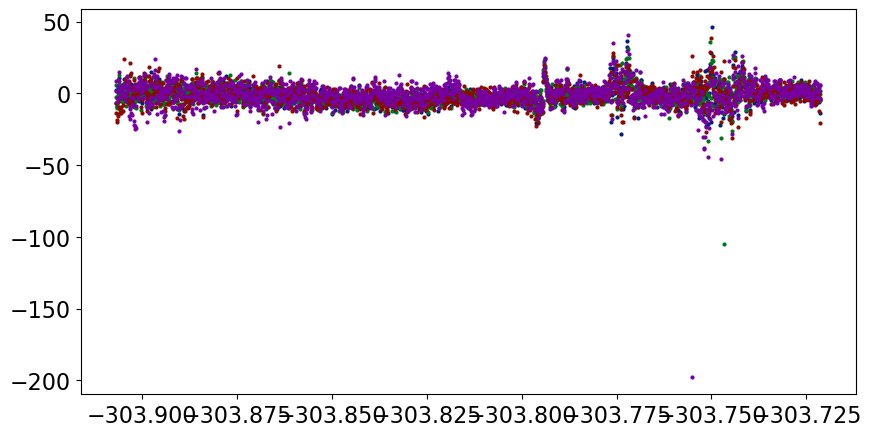

In [117]:
plt.figure(figsize=(10, 5))
plt.plot(data2.bjd, data2.flux, 'o', label='z', ms=2)
plt.plot(data3.bjd, data3.flux, 'o', label='z', ms=2)
plt.plot(data4.bjd, data4.flux, 'o', label='z', ms=2)
plt.plot(data5.bjd, data5.flux, 'o', label='z', ms=2)
plt.show()

In [118]:
# remove outliers 
data2 = data2[np.abs(data2.flux - np.median(data2.flux)) < 3 * np.std(data2.flux)]
data3 = data3[np.abs(data3.flux - np.median(data3.flux)) < 3 * np.std(data3.flux)]
data4 = data4[np.abs(data4.flux - np.median(data4.flux)) < 3 * np.std(data4.flux)]
data5 = data5[np.abs(data5.flux - np.median(data5.flux)) < 3 * np.std(data5.flux)]

In [119]:
print(len(data2), len(data3), len(data4), len(data5))

1746 1748 1747 1756


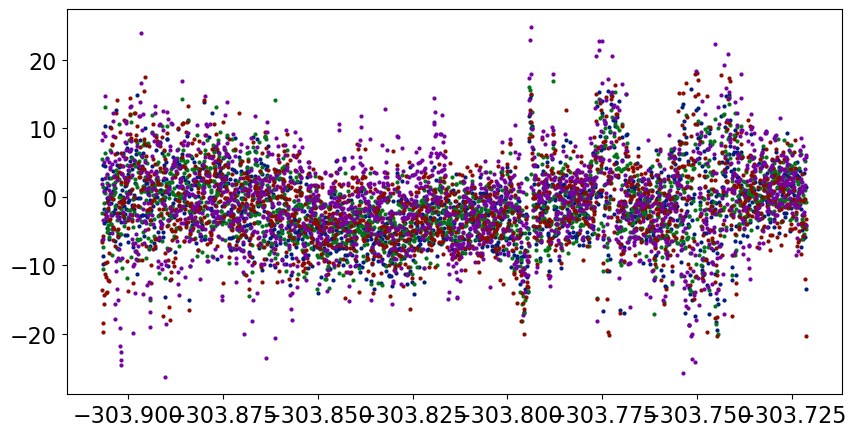

In [120]:
plt.figure(figsize=(10, 5))
plt.plot(data2.bjd, data2.flux, 'o', label='zs', ms=2)
plt.plot(data3.bjd, data3.flux, 'o', label='g', ms=2)
plt.plot(data4.bjd, data4.flux, 'o', label='i', ms=2)
plt.plot(data5.bjd, data5.flux, 'o', label='r', ms=2)
plt.show()

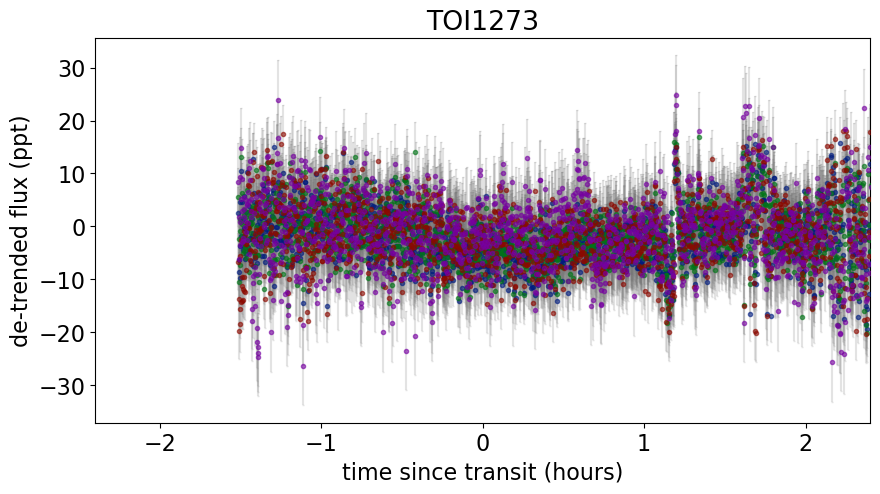

In [121]:
# Plot the folded data, con los parametros del BLS
data2_fold = (data2['bjd'] - bls_t0 + 0.5 * bls_period) % bls_period - 0.5 * bls_period
data3_fold = (data3['bjd'] - bls_t0 + 0.5 * bls_period) % bls_period - 0.5 * bls_period
data4_fold = (data4['bjd'] - bls_t0 + 0.5 * bls_period) % bls_period - 0.5 * bls_period
data5_fold = (data5['bjd'] - bls_t0 + 0.5 * bls_period) % bls_period - 0.5 * bls_period

muscat_time = pd.concat([data2_fold, data3_fold, data4_fold, data5_fold], ignore_index=True)
# datos finales muscat
x_muscat_zs_ = np.ascontiguousarray(data2['bjd'], dtype=np.float64)
x_muscat_g_ = np.ascontiguousarray(data3['bjd'], dtype=np.float64)
x_muscat_i_ = np.ascontiguousarray(data4['bjd'], dtype=np.float64)
x_muscat_r_ = np.ascontiguousarray(data5['bjd'], dtype=np.float64)
y_muscat_zs_ = np.ascontiguousarray(data2['flux'], dtype=np.float64)
y_muscat_g_ = np.ascontiguousarray(data3['flux'], dtype=np.float64)
y_muscat_i_ = np.ascontiguousarray(data4['flux'], dtype=np.float64)
y_muscat_r_ = np.ascontiguousarray(data5['flux'], dtype=np.float64)
yerr_muscat_zs_ = np.ascontiguousarray(data2['flux_err'], dtype=np.float64)
yerr_muscat_g_ = np.ascontiguousarray(data3['flux_err'], dtype=np.float64)
yerr_muscat_i_ = np.ascontiguousarray(data4['flux_err'], dtype=np.float64)
yerr_muscat_r_ = np.ascontiguousarray(data5['flux_err'], dtype=np.float64)

plt.figure(figsize=(10, 5))
plt.plot(data2_fold*24, y_muscat_zs_, '.', label='Muscat2_zs', alpha=0.6, zorder=100)
plt.errorbar(data2_fold*24, y_muscat_zs_, yerr=yerr_muscat_zs_, fmt="none", alpha=0.2, color='#777777', capsize=1, zorder=-100)
plt.plot(data3_fold*24, y_muscat_g_, '.', label='Muscat2_g', alpha=0.6, zorder=100)
plt.errorbar(data3_fold*24, y_muscat_g_, yerr=yerr_muscat_g_, fmt="none", alpha=0.2, color='#777777', capsize=1, zorder=-100)
plt.plot(data4_fold*24, y_muscat_i_, '.', label='Muscat2_i', alpha=0.6, zorder=100)
plt.errorbar(data4_fold*24, y_muscat_i_, yerr=yerr_muscat_i_, fmt="none", alpha=0.2, color='#777777', capsize=1, zorder=-100)
plt.plot(data5_fold*24, y_muscat_r_, '.', label='Muscat2_r', alpha=0.6, zorder=100)
plt.errorbar(data5_fold*24, y_muscat_r_, yerr=yerr_muscat_r_, fmt="none", alpha=0.2, color='#777777', capsize=1, zorder=-100)

plt.ylabel("de-trended flux (ppt)")
plt.xlabel('time since transit (hours)')
plt.xlim(-0.10*24, 0.10*24)
plt.title("TOI1273")
#plt.savefig('new_phot_1199.png',dpi=200,bbox_inches='tight', facecolor='white')
plt.show()

In [122]:
# mask the second half of the transit?
x_muscat_zs = x_muscat_zs_[data2_fold*24<0.5]
x_muscat_g = x_muscat_g_[data3_fold*24<0.5]
x_muscat_i = x_muscat_i_[data4_fold*24<0.5]
x_muscat_r = x_muscat_r_[data5_fold*24<0.5]
y_muscat_zs = y_muscat_zs_[data2_fold*24<0.5]
y_muscat_g = y_muscat_g_[data3_fold*24<0.5]
y_muscat_i = y_muscat_i_[data4_fold*24<0.5]
y_muscat_r = y_muscat_r_[data5_fold*24<0.5]
yerr_muscat_zs = yerr_muscat_zs_[data2_fold*24<0.5]
yerr_muscat_g = yerr_muscat_g_[data3_fold*24<0.5]
yerr_muscat_i = yerr_muscat_i_[data4_fold*24<0.5]
yerr_muscat_r = yerr_muscat_r_[data5_fold*24<0.5]

print(len(x_muscat_zs), len(y_muscat_zs), len(yerr_muscat_zs))
print(len(x_muscat_g), len(y_muscat_g), len(yerr_muscat_g))
print(len(x_muscat_i), len(y_muscat_i), len(yerr_muscat_i))
print(len(x_muscat_r), len(y_muscat_r), len(yerr_muscat_r))

801 801 801
801 801 801
798 798 798
801 801 801


# LC dataset

In [123]:
from collections import OrderedDict

datasets = OrderedDict(
    [
        ("tess", [x, y, yerr, texp]),
        ("keplercam_B", [x_keplercam_B, y_keplercam_B, yerr_keplercam_B, texp_keplercam]),
        ('muscat_zs', [x_muscat_zs, y_muscat_zs, yerr_muscat_zs, texp_muscat]),
        ('muscat_g', [x_muscat_g, y_muscat_g, yerr_muscat_g, texp_muscat]),
        ('muscat_i', [x_muscat_i, y_muscat_i, yerr_muscat_i, texp_muscat]),
        ('muscat_r', [x_muscat_r, y_muscat_r, yerr_muscat_r, texp_muscat])
    ]
)

# Joint model

In [32]:
# These arrays are used as the times/phases where the models are
# evaluated at higher resolution for plotting purposes 
t_rv = np.linspace(x_rv.min() - 5, x_rv.max() + 5, 3000)
phase_lc = np.linspace(-0.3, 0.3, 150)


def build_model(mask=None, start=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    with pm.Model() as model:
        
        # Parameters for the stellar properties
        mean = pm.Normal("mean", mu=0, sd=5)
        u_star = xo.QuadLimbDark("u_star")
        star = xo.LimbDarkLightCurve(u_star)

        BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=3)
        m_star = BoundedNormal("m_star", mu=M_star[0], sd=M_star[1])
        r_star = BoundedNormal("r_star", mu=R_star[0], sd=R_star[1])

        # Orbital parameters for the planets
        t0 = pm.Normal("t0", mu=bls_t0, sd=1)
        log_m_pl = pm.Normal("log_m_pl", mu=np.log(msini.value[0]), sd=1)
        log_period = pm.Normal("log_period", mu=np.log(bls_period), sd=1)

        #b = pm.Uniform("b", lower=0, upper=1.5)

        # # Or sample log_ror directly instead of depth, because b is really close to 1
        log_ror = pm.Normal("log_ror", mu=-2.90, sd=1)
        #log_ror = pm.TruncatedNormal("log_ror", mu=-2.64, sigma=1, upper=-1.9)
        #log_ror = pm.TruncatedNormal("log_ror", mu=-2.90, sigma=1, upper=-1)
        ror = pm.Deterministic("ror", tt.exp(log_ror))
        
        #ror = pm.LogNormal('ror', mu=-2.90, sigma=1)
        b = xo.ImpactParameter('b', ror)
        #b = pm.Uniform("b", lower=0, upper=1.2)
        
        r_pl = pm.Deterministic("r_pl", ror * r_star)

        m_pl = pm.Deterministic("m_pl", tt.exp(log_m_pl))
        period = pm.Deterministic("period", tt.exp(log_period))

        # comentar las proximas tres lineas para versión con e=0 fixed
        ecs = pmx.UnitDisk("ecs", testval=np.array([0.01, 0.01]))
        ecc = pm.Deterministic("ecc", tt.sum(ecs**2))
        omega = pm.Deterministic("omega", tt.arctan2(ecs[1], ecs[0]))

        # RV jitter & a quadratic RV trend
        log_sigma_rv = pm.Normal("log_sigma_rv", mu=np.log(np.median(yerr_rv)), sd=1)
        trend = pm.Normal("trend", mu=0, sd=10.0 ** -np.arange(3)[::-1], shape=3)  # [2,1,0]

        # Transit jitter
        #logs = pm.Uniform("logs", lower=0, upper=1, testval=np.log(np.std(y)))
        logs = pm.Normal("logs", mu=np.log(np.median(yerr)), sd=1)

        # Orbit model
        orbit = xo.orbits.KeplerianOrbit(
            r_star=r_star,
            m_star=m_star,
            period=period,
            t0=t0,
            b=b,
            m_planet=xo.units.with_unit(m_pl, msini.unit),
            ecc=ecc,
            omega=omega,
        )

        # Compute the model light curve
        light_curves = (star.get_light_curve(orbit=orbit, r=r_pl, t=x[mask], texp=texp)* 1e3)
        light_curve = tt.sum(light_curves, axis=-1) + mean
        err_lc = tt.sqrt(yerr[mask]**2 + tt.exp(2*logs)) 

        # The likelihood for the light curve
        pm.Normal("transit_obs", mu=light_curve, sd=err_lc, observed=y[mask])

        # And a function for computing the full RV model
        def get_rv_model(t, name=""):
            # First the RVs induced by the planet
            vrad = orbit.get_radial_velocity(t)
            pm.Deterministic("vrad" + name, vrad)

            # Define the background model
            A = np.vander(t - x_ref, 3) # Generate a Vandermonde matrix with t-x_ref as input vector
            bkg = pm.Deterministic("bkg" + name, tt.dot(A, trend))

            # Sum planet and background to get the full model
            return pm.Deterministic("rv_model" + name, vrad + bkg)


        # Define the model
        rv_model = get_rv_model(x_rv)
        get_rv_model(t_rv, name="_pred")

        # The likelihood for the RVs
        err = tt.sqrt(yerr_rv**2 + tt.exp(2 * log_sigma_rv))
        pm.Normal("obs", mu=rv_model, sd=err, observed=y_rv)

        # Compute and save the phased light curve models
        pm.Deterministic("lc_pred",
            1e3 * star.get_light_curve(orbit=orbit, r=r_pl, t=t0 + phase_lc, texp=texp)[..., 0],)

        # Fit for the maximum a posteriori parameters
        if start is None:
            start = model.test_point
        map_soln = pmx.optimize(start=start)
        map_soln = pmx.optimize(start=map_soln)

        extras = pmx.eval_in_model(light_curves, map_soln)

    return model, map_soln, extras

model0, map_soln0, extras0 = build_model()

message: Desired error not necessarily achieved due to precision loss.
logp: -8908.914108105633 -> -6470.478991650709


message: Desired error not necessarily achieved due to precision loss.
logp: -6470.478991650709 -> -6470.478991650709


Now let's plot the map radial velocity model.

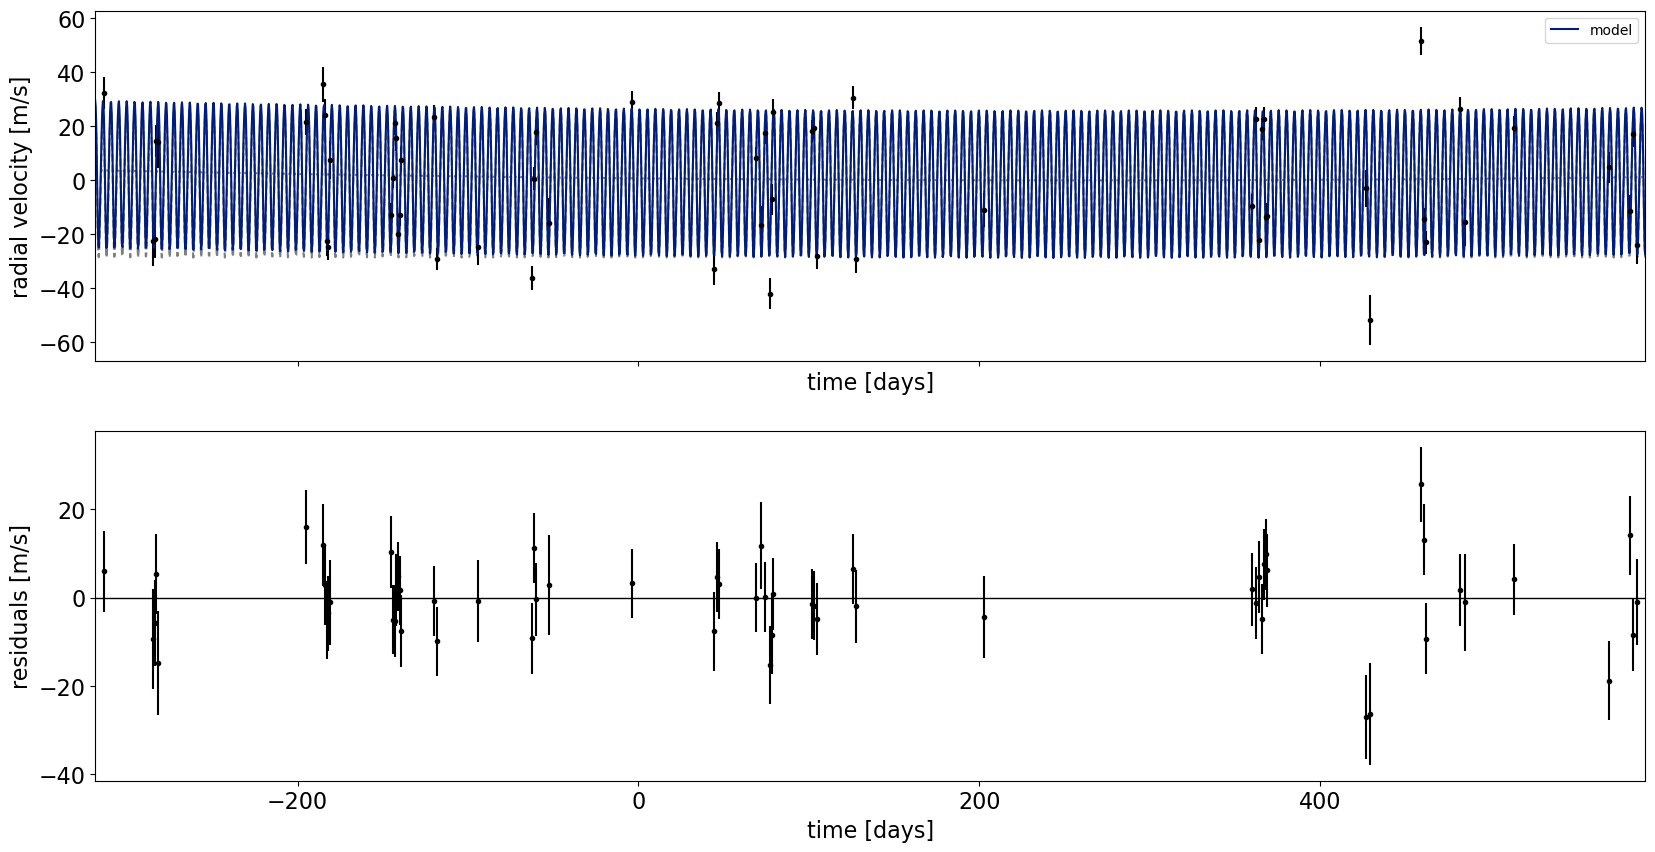

In [33]:
# We plot the initial model:
def plot_rv_curve(soln):
    fig, axes = plt.subplots(2, 1, figsize=(20, 10), sharex=True)
    ax = axes[0]
    ax.errorbar(x_rv, y_rv, yerr=yerr_rv, fmt=".k")
    ax.plot(t_rv, soln['vrad_pred'], "--k", alpha=0.5)
    ax.plot(t_rv, soln['bkg_pred'], ":k", alpha=0.5)
    ax.plot(t_rv, soln['rv_model_pred'], label="model")
    ax.legend(fontsize=10)
    ax.set_xlabel("time [days]")
    ax.set_ylabel("radial velocity [m/s]")
    
    ax = axes[1]
    err = np.sqrt(yerr_rv**2 + np.exp(2 * soln["log_sigma_rv"]))
    ax.errorbar(x_rv, y_rv - soln["rv_model"], yerr=err, fmt=".k")
    ax.axhline(0, color="k", lw=1)
    ax.set_ylabel("residuals [m/s]")
    ax.set_xlim(t_rv.min(), t_rv.max())
    #ax.set_xlim(2200,2300)
    ax.set_xlabel("time [days]")

_ = plot_rv_curve(map_soln0)

Now let's also plot the transit model.

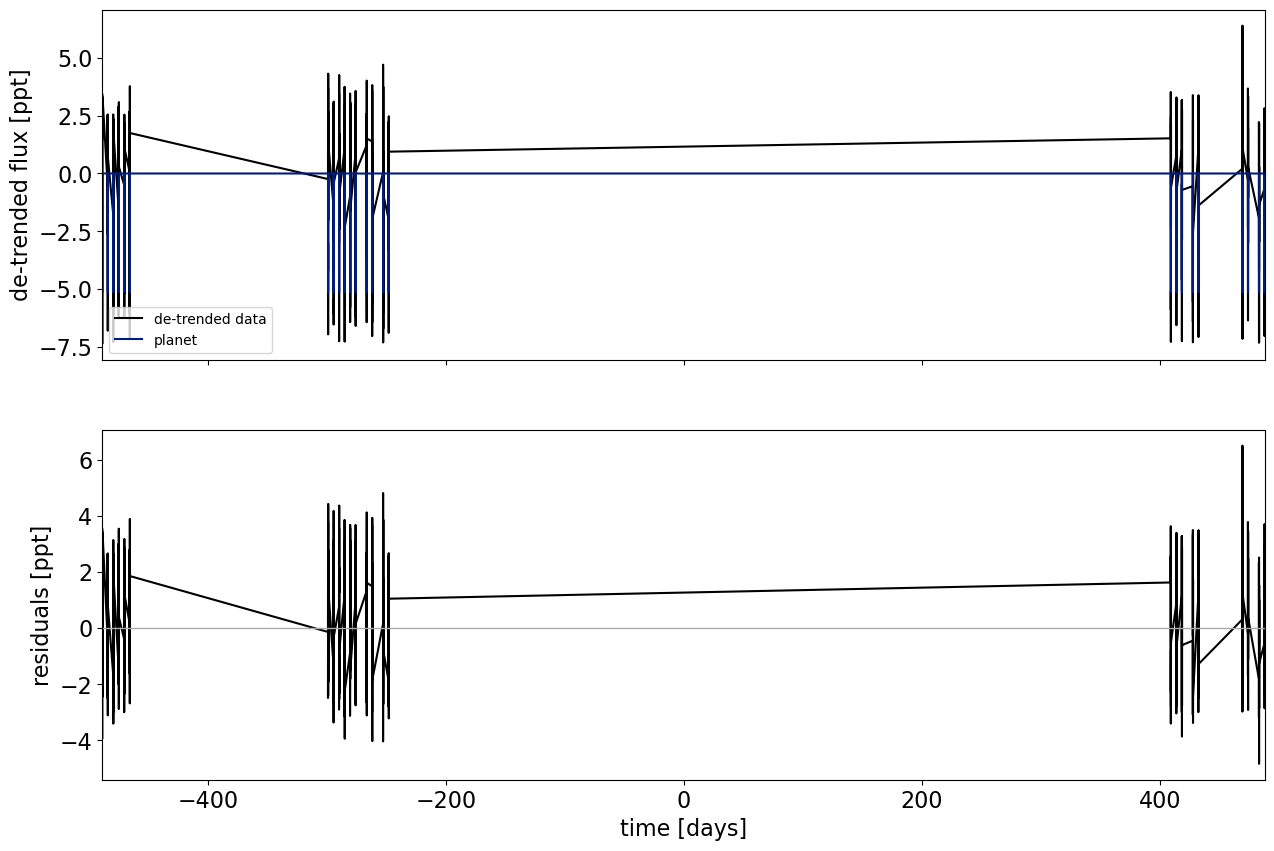

In [34]:
# We plot the initial light curve model:
def plot_light_curve(soln, extras, mask=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)

    fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

    ax = axes[0]
    ax.plot(x[mask], y[mask] - soln['mean'], "k", label="de-trended data")
    mod = extras
    ax.plot(x[mask], mod, label="planet")
    ax.legend(fontsize=10, loc=3)
    ax.set_ylabel("de-trended flux [ppt]")

    ax = axes[1]
    mod = np.sum(extras, axis=-1)
    ax.plot(x[mask], y[mask] - mod, "k")
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("residuals [ppt]")
    ax.set_xlim(x[mask].min(), x[mask].max())
    ax.set_xlabel("time [days]")
    #plt.xlim(-93,-92)
    return fig


_ = plot_light_curve(map_soln0, extras0)

## Sigma clipping

To remove the outliers, we'll look at the empirical RMS of the residuals away from the transit model and remove anything that is more than a 7-sigma outlier.

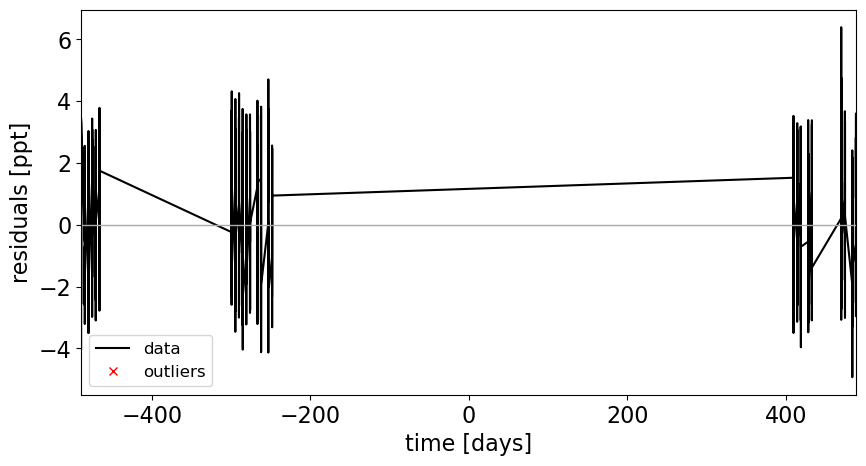

In [35]:
# We can do some sigma clipping to remove significant outliers.
mod = (map_soln0["mean"] + np.sum(extras0, axis=-1))

resid = y - mod
rms = np.sqrt(np.median(resid**2))
mask = np.abs(resid) < 7 * rms

plt.figure(figsize=(10, 5))
plt.plot(x, resid, "k", label="data")
plt.plot(x[~mask], resid[~mask], "xr", label="outliers")
plt.axhline(0, color="#aaaaaa", lw=1)
plt.ylabel("residuals [ppt]")
plt.xlabel("time [days]")
plt.legend(fontsize=12, loc=3)
_ = plt.xlim(x.min(), x.max())
#plt.xlim(-450,-435)

Let's re-build our model with this sigma-clipped dataset.

message: Desired error not necessarily achieved due to precision loss.
logp: -6470.478991650709 -> -6470.478991650709


message: Desired error not necessarily achieved due to precision loss.
logp: -6470.478991650709 -> -6470.478991650709


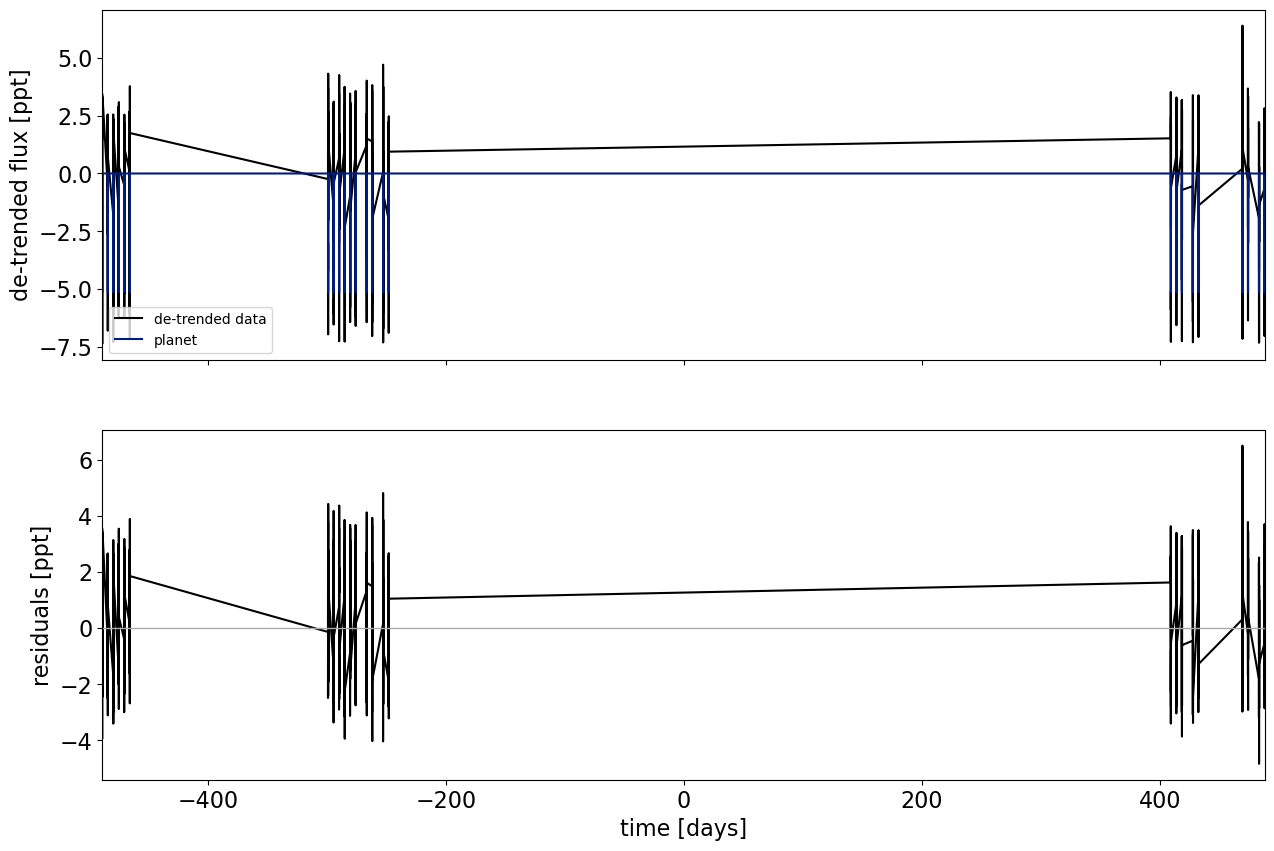

In [36]:
# looks like we don't have any outliers 
model, map_soln, extras = build_model(mask, map_soln0)
_ = plot_light_curve(map_soln, extras, mask)

Great! Now we're ready to sample.

## Sampling

In [37]:
import multiprocessing

with model:
    trace_ = pmx.sample(
        tune=1500, #2500,
        draws=1500, #2000,
        start=map_soln,
        cores=4, #4
        chains=2, #4
        target_accept=0.95,
        return_inferencedata=True,
        random_seed=[203771098, 203775000],#, 261136679, 261136680],
        init="adapt_full",
    )

Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logs, trend, log_sigma_rv, ecs, b, log_ror, log_period, log_m_pl, t0, r_star, m_star, u_star, mean]
NUTS: [logs, trend, log_sigma_rv, ecs, b, log_ror, log_period, log_m_pl, t0, r_star, m_star, u_star, mean]


In [ ]:
import arviz as az

# Multitrace to InferenceData
trace = az.from_pymc3(trace=trace_)

# version con e libre
# az.to_netcdf(trace, 'trace.toi1273.save')
##trace = az.from_netcdf('trace.toi1273.save')

# version con e=0 fixed
# az.to_netcdf(trace, 'trace.toi1273_noecc.save')
# trace = az.from_netcdf('trace.toi1273_noecc.save')

'trace.toi1273.save'

Let's look at the convergence diagnostics for some of the key parameters:

In [ ]:
import arviz as az

all_vars = ['logs','trend','log_sigma_rv','log_ror','b','log_period','log_m_pl','t0','r_star','m_star','u_star','mean','period',"r_pl","m_pl",'ror',"ecc","omega",'ecs']

az.summary(
    trace, stat_funcs={'median': np.median, 'std':np.std}, hdi_prob=0.68, round_to=6,
    var_names=all_vars)

,mean,sd,hdi_16%,hdi_84%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,median,std
logs,-2.276082,0.438788,-2.580733,-1.767792,0.005454,0.004247,8196.219871,4360.958557,1.000385,-2.227632,0.438760
trend[0],0.000013,0.000035,-0.000022,0.000048,0.000000,0.000000,8479.632526,5664.255855,1.000375,0.000013,0.000035
trend[1],0.009878,0.009667,0.000290,0.019369,0.000103,0.000088,8823.923830,5224.402174,1.000442,0.009865,0.009667
trend[2],0.307728,0.939744,-0.647860,1.200746,0.009731,0.010642,9368.059262,5826.007984,1.000327,0.307963,0.939685
log_sigma_rv,2.432141,0.129268,2.307476,2.562345,0.001465,0.001040,7850.742894,5188.643596,1.000507,2.429189,0.129259
log_ror,-2.055872,0.440052,-2.459153,-2.019730,0.025764,0.018236,761.090142,268.585359,1.000076,-2.185404,0.440024
b,1.018362,0.149576,0.936890,1.011952,0.010052,0.007141,778.548241,268.628151,1.000193,0.981021,0.149567
log_period,1.532837,0.000001,1.532837,1.532838,0.000000,0.000000,10313.404612,5704.834505,0.999793,1.532837,0.000001
log_m_pl,4.398056,0.077442,4.320872,4.473667,0.000822,0.000581,9123.305861,4725.434757,1.000641,4.400878,0.077437
t0,-489.090261,0.000529,-489.090766,-489.089742,0.000008,0.000006,5885.036179,3131.978496,1.000073,-489.090255,0.000529


In [ ]:
from uncertainties import ufloat
from uncertainties.umath import *

logsigma_rv_mean = trace.posterior["log_sigma_rv"].mean().item()
logsigma_rv = ufloat(logsigma_rv_mean, trace.posterior["log_sigma_rv"].std().item())
rv_jitter_ = np.e**logsigma_rv
tess_jitter_mean = trace.posterior['logs'].mean().item()
tess_jitter = ufloat(tess_jitter_mean, trace.posterior['logs'].std().item())
tess_jitter_val = np.e**tess_jitter


radio = (trace.posterior["r_pl"].mean().item()*u.R_sun).to(u.R_jup).value
radio_err = (trace.posterior["r_pl"].std().item()*u.R_sun).to(u.R_jup).value
masa = (trace.posterior["m_pl"].mean().item()*u.M_earth).to(u.M_jup).value
masa_err = (trace.posterior["m_pl"].std().item()*u.M_earth).to(u.M_jup).value
periodo = trace.posterior['period'].mean().item()
periodo_sigma = trace.posterior['period'].std().item()
t_0 = trace.posterior['t0'].mean().item()+ref_time
t_0_sigma = trace.posterior['t0'].std().item()
print("Radio = {r:.3f} \u00B1 {r_err:.3f} Rj".format(r=radio, r_err=radio_err))
print("Masa = {m:.3f} \u00B1 {m_err:.3f} Mj".format(m=masa, m_err=masa_err))
print("Periodo = {p:.6f} \u00B1 {p_s:.6f}".format(p=periodo, p_s=periodo_sigma))
print("Epoca = {e:.5f} \u00B1 {e_s:.4f}".format(e=t_0, e_s=t_0_sigma))
print("RV jitter = ", rv_jitter_)
print("TESS jitter = ", tess_jitter_val)

Radio = 1.554 ± 1.438 Rj
Masa = 0.257 ± 0.020 Mj
Periodo = 4.631298 ± 0.000003
Epoca = 1712.34661 ± 0.0005
RV jitter =  11.4+/-1.5
TESS jitter =  0.10+/-0.05


In [ ]:
# Posterior constraints: rho>0.1 g/cc, log_ror<-1.9, ror<1.5
trace2 = trace.copy()
samps = trace2.posterior.stack(sample=("chain", "draw"))
index = samps['r_pl'] < 0.15
radio2 = (samps['r_pl'][index].mean().item()*u.R_sun).to(u.R_jup).value
radio2_err = (samps['r_pl'][index].std().item()*u.R_sun).to(u.R_jup).value
masa2 = (samps['m_pl'][index].mean().item()*u.M_earth).to(u.M_jup).value
masa2_err = (samps['m_pl'][index].std().item()*u.M_earth).to(u.M_jup).value
print("Radio2 = {r:.3f} \u00B1 {r_err:.3f} Rj".format(r=radio2, r_err=radio2_err))
print("Masa2 = {m:.3f} \u00B1 {m_err:.3f} Mj".format(m=masa2, m_err=masa2_err))

Radio2 = 1.111 ± 0.155 Rj
Masa2 = 0.257 ± 0.020 Mj


In [ ]:
# Posterior constraints: rho>0.1 g/cc, log_ror<-1.9, ror<1.5
trace2 = trace.copy() # az.InferenceData
posterior = az.extract_dataset(trace2) # xarray.Dataset 
posterior_subset = posterior.where(posterior["r_pl"] < 0.15, drop=True) # xarray.Dataset
trace_subset = az.convert_to_inference_data(posterior_subset) # az.InferenceData

In [ ]:
logsigma_rv_mean = trace.posterior["log_sigma_rv"].mean().item()
logsigma_rv = ufloat(logsigma_rv_mean, trace.posterior["log_sigma_rv"].std().item())
rv_jitter_ = np.e**logsigma_rv
tess_jitter_mean = trace.posterior['logs'].mean().item()
tess_jitter = ufloat(tess_jitter_mean, trace.posterior['logs'].std().item())
tess_jitter_val = np.e**tess_jitter
radio2 = (trace_subset.posterior["r_pl"].mean().item()*u.R_sun).to(u.R_jup).value
radio2_err = (trace_subset.posterior["r_pl"].std().item()*u.R_sun).to(u.R_jup).value
masa2 = (trace_subset.posterior["m_pl"].mean().item()*u.M_earth).to(u.M_jup).value
masa2_err = (trace_subset.posterior["m_pl"].std().item()*u.M_earth).to(u.M_jup).value
periodo2 = trace_subset.posterior['period'].mean().item()
periodo2_sigma = trace_subset.posterior['period'].std().item()
t_02 = trace_subset.posterior['t0'].mean().item()+ref_time
t_02_sigma = trace_subset.posterior['t0'].std().item()
G = 6.6743e-11
teff = ufloat(5697,62)
smaxis = ((ufloat(periodo2*u.day.to(u.second),periodo2_sigma*u.day.to(u.second)))**2*G*(ufloat(trace_subset.posterior['m_star'].mean().item()*u.M_sun.to(u.kg), trace_subset.posterior['m_star'].std().item()*u.M_sun.to(u.kg))+
            ufloat(masa2*u.M_jup.to(u.kg), masa2_err*u.M_jup.to(u.kg)))/(4*np.pi**2))**(1/3)*u.m.to(u.au)
teq = teff*(ufloat(trace_subset.posterior['r_star'].mean().item()*u.R_sun.to(u.au), trace_subset.posterior['r_star'].std().item()*u.R_sun.to(u.au))/smaxis)**(1/2)*(1/4)**(1/4)
print("Radio2 = {r:.4f} \u00B1 {r_err:.4f} Rj".format(r=radio2, r_err=radio2_err))
print("Masa2 = {m:.3f} \u00B1 {m_err:.3f} Mj".format(m=masa2, m_err=masa2_err))
print("Periodo2 = {p:.6f} \u00B1 {p_s:.6f}".format(p=periodo2, p_s=periodo2_sigma))
print("Epoca = {e:.5f} \u00B1 {e_s:.4f}".format(e=t_02, e_s=t_02_sigma))
print('Semieje mayor = {s:.4f} au'.format(s=smaxis))
print('Temperatura de equilibrio= {t:.3f} K'.format(t=teq))
print("RV jitter = ", rv_jitter_)
print("TESS jitter = ", tess_jitter_val)

Radio2 = 1.1106 ± 0.1550 Rj
Masa2 = 0.257 ± 0.020 Mj
Periodo2 = 4.631298 ± 0.000003
Epoca = 1712.34664 ± 0.0005
Semieje mayor = 0.0540+/-0.0004 au
Temperatura de equilibrio= 1222.521+/-21.047 K
RV jitter =  11.4+/-1.5
TESS jitter =  0.10+/-0.05


In [ ]:
# trace_subset.posterior['trend'][2].std().item()

0.9336813830137484

In [ ]:
# resultado con e libre
# Radio2 = 1.126 ± 0.149 Rj
# Masa2 = 0.257 ± 0.020 Mj
# Periodo2 = 4.631298 ± 0.000003
# Epoca = 1712.34663 ± 0.0004
# Semieje mayor= 0.0540+/-0.0004 au
# Temperatura de equilibrio= 1222.412+/-20.950 K

In [ ]:
dim1_vars = ['logs', 'log_sigma_rv', 'log_ror', 'b', 'log_period', 'log_m_pl', 't0', 
            'r_star', 'm_star', 'mean', 'period', "r_pl", "m_pl", "ecc", "omega", 'ror'] # faltan 'u_star' (dim2), 'ecs' (dim2), 'trend' (dim3)
dict2 = {}
for i in dim1_vars:
        dict2[i] = samps[i][index].values
az.summary(
    dict2, stat_funcs={'median': np.median, 'std':np.std}, hdi_prob=0.68, round_to=6,
    var_names=dim1_vars)

arviz - WARNING - Shape validation failed: input_shape: (1, 5975), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_16%,hdi_84%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,median,std
logs,-2.273585,0.435273,-2.587694,-1.779797,0.006519,0.004923,5241.767842,3680.191223,NaN,-2.227375,0.435237
log_sigma_rv,2.431685,0.130360,2.316354,2.572756,0.001709,0.001212,5851.083056,3960.984839,NaN,2.428496,0.130349
log_ror,-2.247156,0.132568,-2.415435,-2.132695,0.001828,0.001297,5153.493793,4812.106653,NaN,-2.256159,0.132557
b,0.970577,0.023548,0.947275,0.994780,0.000386,0.000273,3706.173860,3809.146760,NaN,0.970084,0.023547
log_period,1.532837,0.000001,1.532837,1.532838,0.000000,0.000000,6859.546931,4396.357713,NaN,1.532837,0.000001
log_m_pl,4.399439,0.077156,4.329858,4.482135,0.000994,0.000703,6113.078823,3554.833505,NaN,4.401669,0.077149
t0,-489.090237,0.000506,-489.090726,-489.089724,0.000006,0.000004,6568.537796,4473.747514,NaN,-489.090238,0.000506
r_star,1.069784,0.027631,1.043640,1.097457,0.000374,0.000264,5468.585953,3998.656591,NaN,1.070164,0.027629
m_star,0.980190,0.019705,0.962355,1.001668,0.000263,0.000186,5601.771750,4353.924591,NaN,0.980000,0.019703
mean,0.103810,0.030707,0.075421,0.135370,0.000383,0.000276,6423.371888,4797.464474,NaN,0.103688,0.030704


In [ ]:
var_names=['m_pl', 'r_pl', 'b', 'ecc', 'omega']
dict1 = {}
for i in var_names:
        dict1[i] = samps[i][index].values

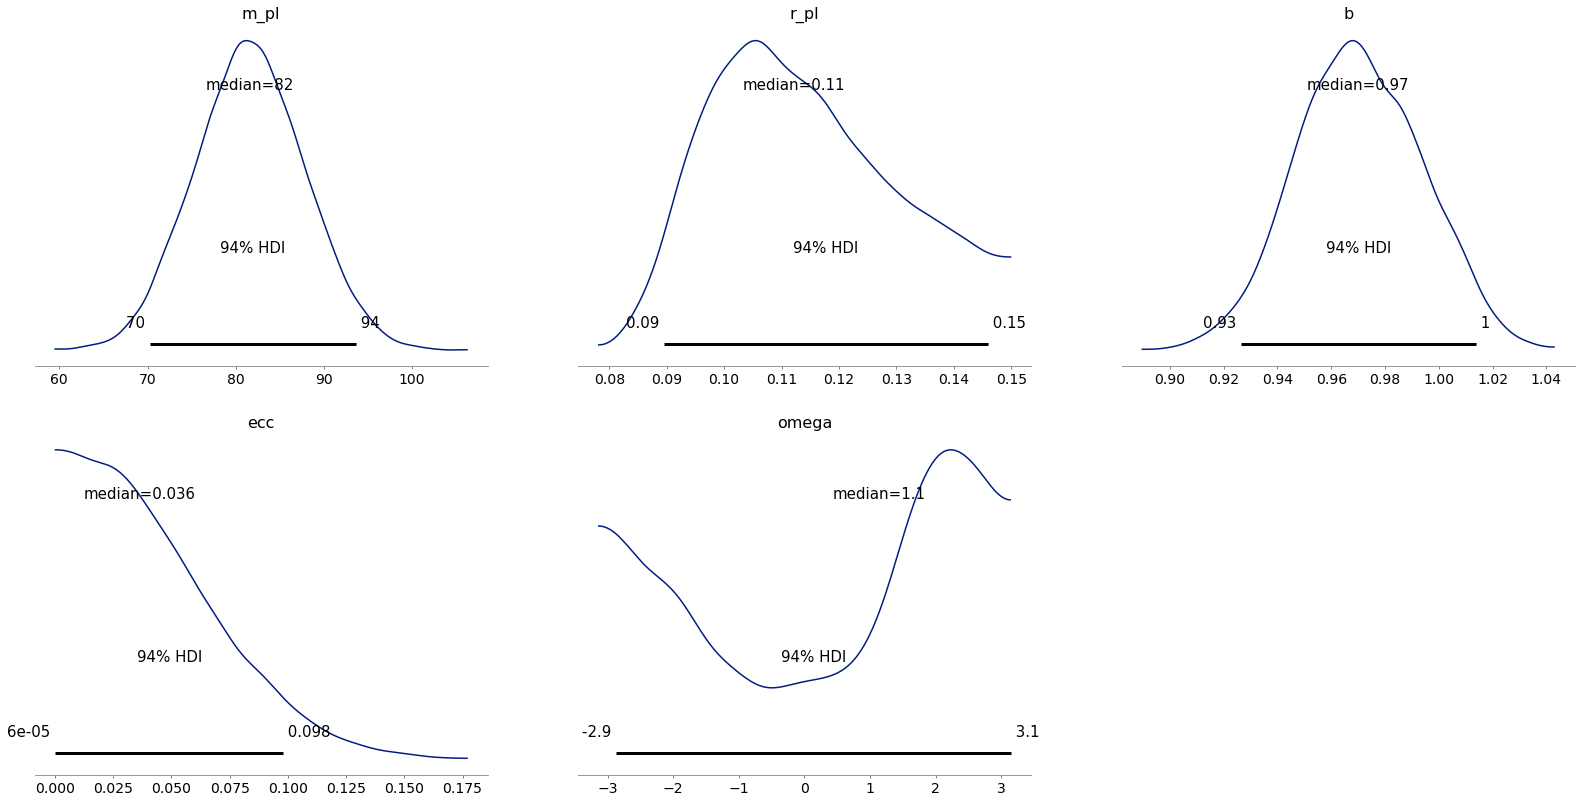

In [ ]:
az.plot_posterior(posterior_subset, var_names=['m_pl', 'r_pl', 'b', 'ecc', 'omega'], 
                    combine_dims={"sample"}, point_estimate='median')

plt.show()

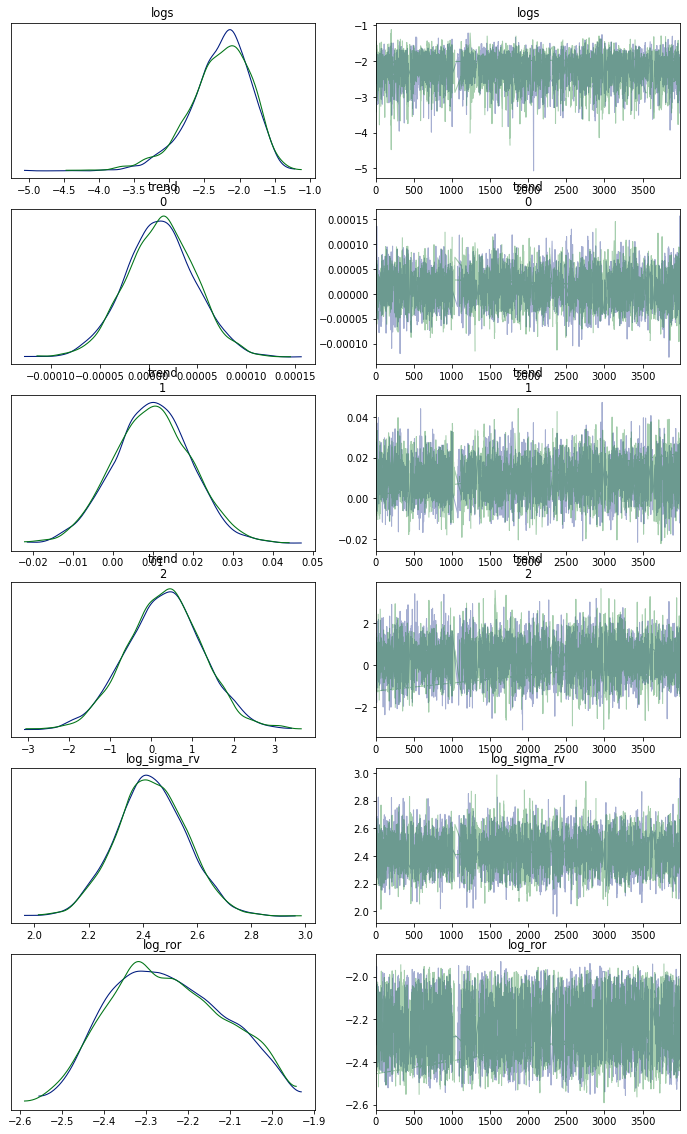

In [ ]:
from arviz.utils import Numba
Numba.disable_numba()
Numba.numba_flag


_ = az.plot_trace(trace_subset.unstack(), var_names=['logs', 'trend','log_sigma_rv', 'log_ror'] # trace or trace_subset.stack()
                                    , compact=False, figsize=(12,20)) 
# plt.savefig('trace_joint_1273_reparam_3.png',dpi=200,bbox_inches='tight')

In [ ]:
dict1['r_pl'] = dict1['r_pl']*9.73116

In [ ]:
CORNER_KWARGS = dict(
    smooth=0.9,
    plot_density=False,
    plot_datapoints=False,
    fill_contours=True,
    #levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)),
    levels=(0.16,0.5,0.84),
    max_n_ticks=3
)

<Figure size 1008x1008 with 0 Axes>

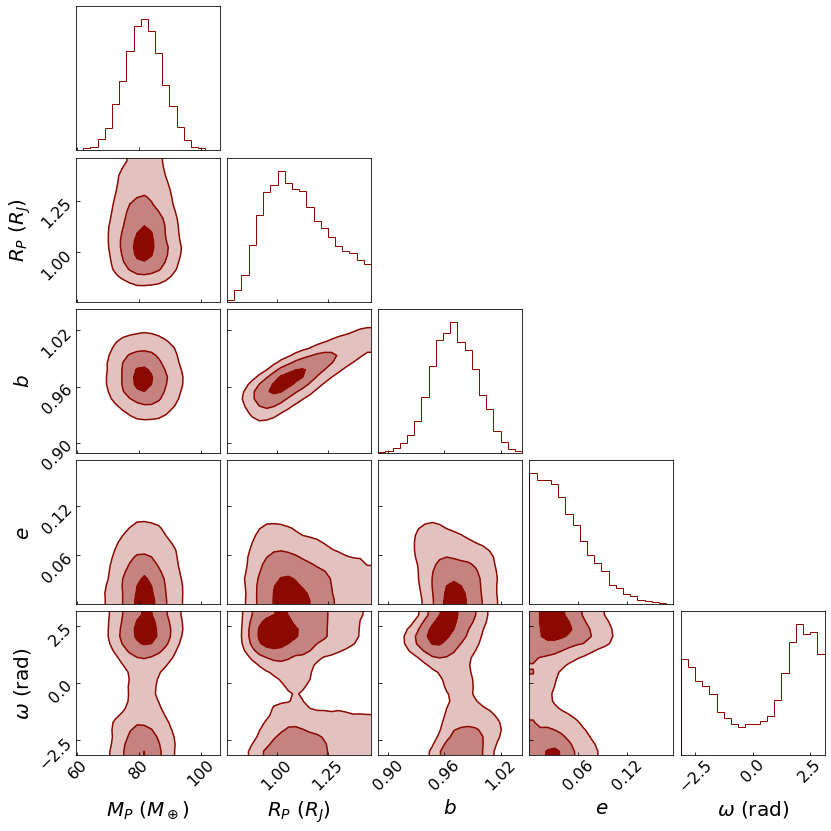

In [ ]:
from cProfile import label
import corner

plt.figure(figsize=(14,14))
# figure = corner.corner(dict1, var_names=['m_pl', 'r_pl', 'b', 'ecc', 'omega'],#, 'omega'], 
#                         labels=[r"$M_P ~(M_\oplus)$", r"$R_P ~(R_{J})$", r"$b$", r"$e$", r"$\omega$ (rad)"], label_kwargs={'fontsize':20},#, r"$\omega$ (rad)"],
#                         show_titles=True, title_kwargs={'fontsize':20, 'pad':9.0}, titles=['$M_P$','$R_P$','$b$','$e$', '$\omega$'], divergences=True, plot_contours=True,
#                         labelpad=0, color='C2', quantiles=[0.16, 0.5, 0.84], **CORNER_KWARGS) #, quantiles=[0.16, 0.5, 0.84],
figure = corner.corner(dict1, var_names=['m_pl', 'r_pl', 'b', 'ecc', 'omega'],#, 'omega'], 
                        labels=[r"$M_P ~(M_\oplus)$", r"$R_P ~(R_{J})$", r"$b$", r"$e$", r"$\omega$ (rad)"], label_kwargs={'fontsize':20},#, r"$\omega$ (rad)"],
                        show_titles=False, title_kwargs={'fontsize':20, 'pad':9.0}, titles=['$M_P$','$R_P$','$b$','$e$', '$\omega$'], divergences=True, plot_contours=True,
                        labelpad=0, color='C2', **CORNER_KWARGS) #, quantiles=[0.16, 0.5, 0.84],
for ax in figure.get_axes():
    ax.tick_params(axis='both', pad=1, direction='in', labelbottom=True, labelleft=True, left=True, bottom=True)
#plt.savefig('corner_1273_paper.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

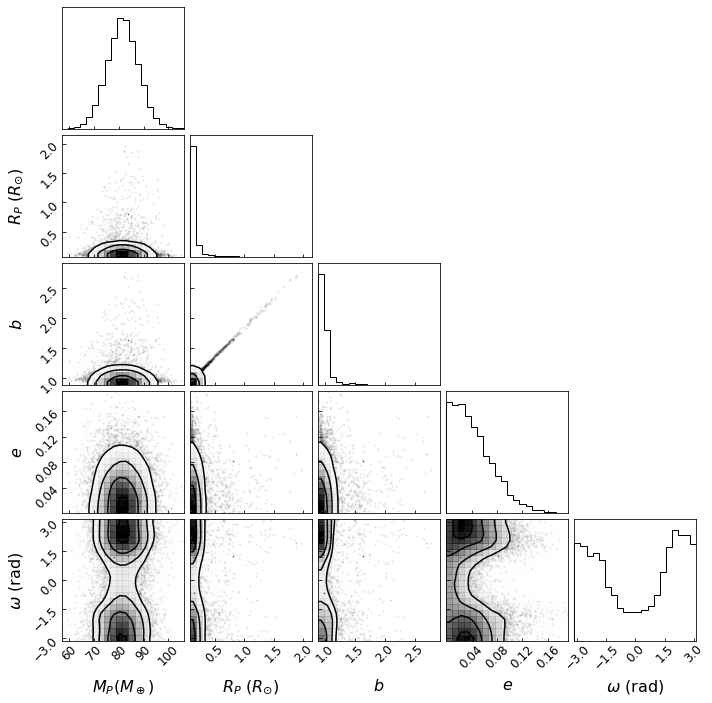

In [ ]:
import corner

figure = corner.corner(trace2, var_names=['m_pl', 'r_pl', 'b', 'ecc', 'omega'], 
                        labels=[r"$M_P (M_\oplus)$", r"$R_P ~(R_{\odot})$", r"$b$", r"$e$", r"$\omega$ (rad)"],
                        show_titles=False, title_kwargs={'fontsize':10}, divergences=True, plot_contours=True,
                        smooth=True) 
#figure.subplots_adjust(right=1, top=1)
figure.set_size_inches(10,10)
for ax in figure.get_axes():
    ax.tick_params(axis='both', labelsize=12, pad=1, direction='in')

#plt.savefig('corner_paper_1273.png',dpi=200,bbox_inches='tight')

## Phase plots

In [ ]:
flat_samps = trace.posterior.stack(sample=("chain", "draw"))

# Get the posterior median orbital parameters
# p_ = np.median(flat_samps["period"])
# t0_ = np.median(flat_samps["t0"])
# mean = np.median(flat_samps["mean"])

p_ = trace_subset.posterior['period'].median().item()
t0_ = trace_subset.posterior['t0'].median().item()
mean = trace_subset.posterior['mean'].median().item()

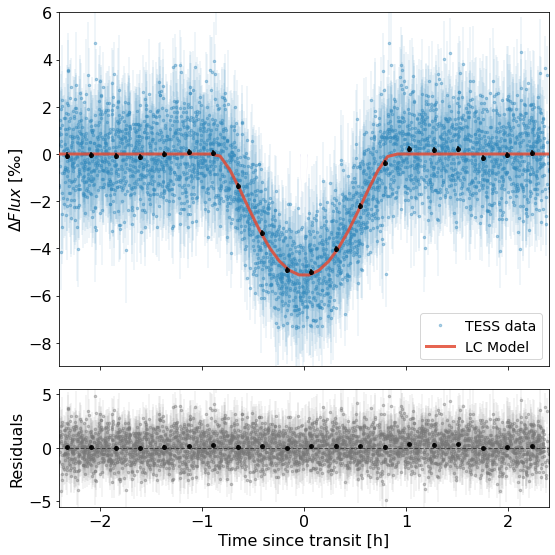

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True, gridspec_kw={'height_ratios': [3,1]})
# Plot the folded data
x_fold2 = (x[mask] - t0_ + 0.5 * p_) % p_ - 0.5 * p_
ax1.plot(x_fold2*24, y[mask] - mean, '.', color='#348ABD', label="TESS data", zorder=-1000, alpha=0.4, ms=5)
ax1.errorbar(x_fold2*24, y[mask] - mean, yerr=yerr[mask], color='#348ABD', fmt="none", capsize=0, zorder=-1000, alpha=0.1)

# Overplot the phase binned light curve
lcc = lk.LightCurve(time=x_fold2, flux=y - mean, flux_err=yerr)
lcc_binned = lcc.bin(time_bin_size=0.01)
ax1.errorbar(lcc_binned['time'].value*24, lcc_binned['flux'].value, yerr=lcc_binned['flux_err'].value, fmt='o', color='k', 
                 ms=5, markeredgecolor='k', markerfacecolor='k', markeredgewidth=0, alpha=0.9, zorder=900)

# Plot the model
pred = np.percentile(trace_subset.posterior['lc_pred'], [16, 50, 84], axis=-1)
ax1.plot(phase_lc*24, pred[1], color='#E24A33', label="LC Model", zorder=800, linewidth=3, alpha=0.85)
art = ax1.fill_between(phase_lc, pred[0], pred[2], color="#988ED5", alpha=0.5, zorder=800)
art.set_edgecolor("none")

ax1.legend(fontsize=14, loc=4)
ax1.set_ylabel(u'$\Delta Flux$ [‰]')
ax1.set_xlim(-0.10*24, 0.10*24)
ax1.set_ylim(-9,6)
ax1.set_yticks([-8,-6,-4,-2,0,2,4,6])

# Plot the residuals
ax2.axhline(y=0, ls='--', color='k', linewidth=1, alpha=0.5)
ax2.plot(x_fold2*24, y[mask] - np.sum(extras, axis=-1), ".", color='#777777', zorder=-1000, alpha=0.4, ms=5)
ax2.errorbar(x_fold2*24, y[mask] - np.sum(extras, axis=-1), yerr=yerr[mask], color='#777777', label="data", fmt="none", capsize=0, zorder=-1000, alpha=0.1)
# Overplot the phase binned residuals
lcc2 = lk.LightCurve(time=x_fold2, flux=y - np.sum(extras, axis=-1), flux_err=yerr)
lcc2_binned = lcc2.bin(time_bin_size=0.01)
ax2.errorbar(lcc2_binned['time'].value*24, lcc2_binned['flux'].value, yerr=lcc2_binned['flux_err'].value, fmt='o', color='k', 
                 ms=5, markeredgecolor='k', markerfacecolor='k', markeredgewidth=0, alpha=0.9, zorder=900)
ax2.set_ylabel('Residuals')
ax2.set_xlabel("Time since transit [h]")
ax2.set_ylim(-5.5,5.5)
plt.tight_layout()
#plt.savefig('fit_transit_joint_1273.png', dpi=300, bbox_inches='tight', facecolor='white')

In [ ]:
rv_jitter = np.exp(trace_subset.posterior['log_sigma_rv'].median().item())
bkg_ = np.median(trace_subset.posterior['bkg'].values, axis=-1)
rv_model_ = np.median(trace_subset.posterior['rv_model'].values, axis=-1)

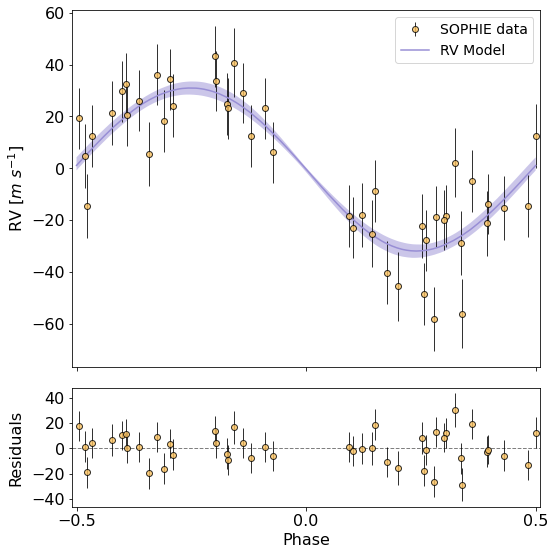

In [ ]:
# Plot the folded data
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True, gridspec_kw={'height_ratios': [3,1]})
x_fold = (x_rv - t0_ + 0.5 * p_) % p_ - 0.5 * p_
ax1.errorbar(x_fold/p_, y_rv - bkg_, yerr=np.sqrt(yerr_rv**2+rv_jitter**2), fmt="o", color='#FBC15E', 
            markeredgecolor='k', ecolor='k', elinewidth=1, label='SOPHIE data', alpha=0.8)

# Compute the posterior prediction for the folded RV model 
t_fold = (t_rv - t0_ + 0.5 * p_) % p_ - 0.5 * p_
inds = np.argsort(t_fold)
pred = np.percentile(trace_subset.posterior['vrad_pred'][inds],[16, 50, 84], axis=-1)
ax1.plot(t_fold[inds]/p_, pred[1], color="#988ED5", label="RV Model")
art = ax1.fill_between(t_fold[inds]/p_, pred[0], pred[2], color="#988ED5", alpha=0.5)
art.set_edgecolor("none")
ax1.set_xlim(-0.51, 0.51)
ax1.set_ylabel("RV [$m~s^{-1}$]")
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles[::-1], labels[::-1],fontsize=14, loc='best')

# Plot the folded residuals
ax2.axhline(y=0, ls='--', color='k', linewidth=1, alpha=0.5)
ax2.errorbar(x_fold/p_, y_rv-rv_model_ - bkg_, yerr=np.sqrt(yerr_rv**2+rv_jitter**2), fmt="o", color='#FBC15E',
            markeredgecolor='k', ecolor='k', elinewidth=1, alpha=0.8, label='residuals')
ax2.set_ylabel('Residuals', labelpad=8)
ax2.set_xlabel("Phase")
ax2.set_xlim(-0.51, 0.51)
ax2.set_xticks([-0.5, 0, 0.5])
ax2.set_yticks([-40, -20, 0, 20, 40])
plt.tight_layout()
#plt.savefig('fit_rv_joint_1273.png', dpi=300, bbox_inches='tight', facecolor='white')

In [ ]:
from uncertainties import ufloat
from uncertainties.umath import *

rpl = ufloat((radio *u.R_jup).to(u.cm).value, (radio_err *u.R_jup).to(u.cm).value)  
mpl = ufloat((masa *u.M_jup).to(u.g).value, (masa_err *u.M_jup).to(u.g).value)

rpl2 = ufloat((radio2 *u.R_jup).to(u.cm).value, (radio2_err *u.R_jup).to(u.cm).value)  
mpl2 = ufloat((masa2 *u.M_jup).to(u.g).value, (masa2_err *u.M_jup).to(u.g).value)

densidad1 = mpl * 1/(4 / 3 * np.pi * rpl**3)
densidad2 = mpl2 * 1/(4 / 3 * np.pi * rpl2**3)

print('densidad1', densidad1)
print('densidad2', densidad2)

densidad1 0.08+/-0.24
densidad2 0.23+/-0.10


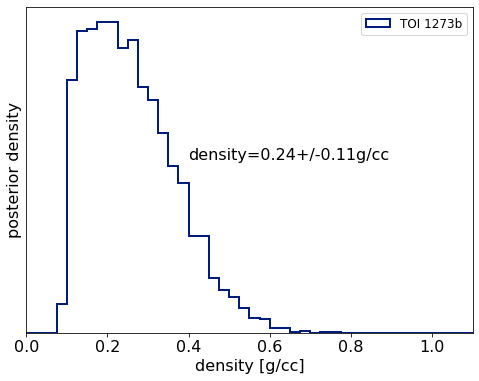

In [ ]:
volume = 4 / 3 * np.pi * trace_subset.posterior['r_pl'] ** 3
density = u.Quantity(trace_subset.posterior['m_pl'] / volume, unit=u.M_earth / u.R_sun**3)
density = density.to(u.g / u.cm**3).value

bins = np.linspace(0, 1.1, 45)
plt.hist(
        density,
        bins,
        histtype="step",
        lw=2,
        label='TOI 1273b',
        density=True,)
plt.yticks([])
plt.text(0.4, 2, 'density={:.2f}+/-{:.2f}g/cc'.format(np.median(density),np.std(density)))
plt.legend(fontsize=12)
plt.xlim(bins[0], bins[-1])
plt.xlabel("density [g/cc]")
_ = plt.ylabel("posterior density")
#plt.savefig('density_joint_1273_reparam.png',dpi=200,bbox_inches='tight')

We can also compute the posterior constraints on the planet densitiy.

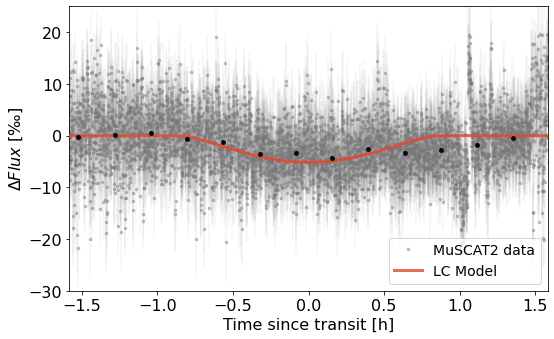

In [ ]:
from scipy import stats
# Plot the folded data
plt.figure(figsize=(8,5))
plt.plot(x_conc1, y_conc1 - 1e3, '.', color='#777777', ms=5, label='MuSCAT2 data', zorder=-1000, alpha=0.4)
plt.errorbar(x_conc1, y_conc1 - 1e3, yerr=yerr_conc1, fmt='none', color='#777777', capsize=0, alpha=0.08, zorder=-1000)

# Plot the model
pred = np.percentile(flat_samps["lc_pred"], [16, 50, 84], axis=-1)
plt.plot(phase_lc*24, pred[1], color="#E24A33", label="LC Model", linewidth=3, alpha=0.8, zorder=900)
plt.fill_between(phase_lc*24, pred[0], pred[2], color="#E24A33", alpha=0.5)
# Plot the binned lightcurve
lcc = lk.LightCurve(time=x_conc1, flux=y_conc1-1e3, flux_err=yerr_conc1)
lcc_binned = lcc.bin(time_bin_size=0.01*24)
plt.errorbar(lcc_binned['time'].value, lcc_binned['flux'].value, yerr=lcc_binned['flux_err'].value,  fmt='o', color='k', 
                 ms=5, markeredgecolor='k', markerfacecolor='k', markeredgewidth=0, alpha=0.9, zorder=900)
plt.legend(fontsize=14, loc=4)
plt.ylabel(u'$\Delta Flux$ [‰]')
plt.xlabel("Time since transit [h]")
plt.xlim(-0.066*24, 0.066*24)
#plt.xlim(-0.10*24, 0.10*24)
plt.ylim(-30, 25)
plt.tight_layout()
#plt.savefig('new_phot_1273_muscat2.png', dpi=300,bbox_inches='tight', facecolor='white')
plt.show()

In [ ]:
oot_mask2 = bls.transit_mask(data2['time'], p_, bls_duration, t0_)
oot_mask3 = bls.transit_mask(data3['time'], p_, bls_duration, t0_)
oot_mask4 = bls.transit_mask(data4['time'], p_, bls_duration, t0_)
oot_mask5 = bls.transit_mask(data5['time'], p_, bls_duration, t0_)

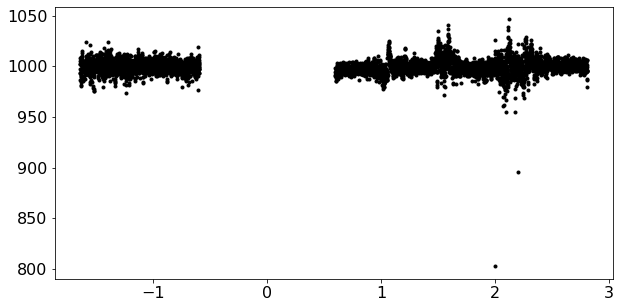

In [ ]:
# checking the oot mask
plt.figure(figsize=(10, 5))
plt.plot((data2_fold*24)[~oot_mask2], data2['flux'][~oot_mask2] - mean, ".k")
plt.plot((data3_fold*24)[~oot_mask3], data3['flux'][~oot_mask3] - mean, ".k")
plt.plot((data4_fold*24)[~oot_mask4], data4['flux'][~oot_mask4] - mean, ".k")
plt.plot((data5_fold*24)[~oot_mask5], data5['flux'][~oot_mask5] - mean, ".k")

In [ ]:
# fitemos un pol grado 2 a los datos oot
x_oot = np.concatenate(((data2_fold*24)[~oot_mask2], (data3_fold*24)[~oot_mask3], (data4_fold*24)[~oot_mask4]
                        ,(data5_fold*24)[~oot_mask5] ), axis=None)
y_oot = np.concatenate((data2['flux'][~oot_mask2], data3['flux'][~oot_mask3], data4['flux'][~oot_mask4]
                        ,data5['flux'][~oot_mask5] ), axis=None)
z = np.polyfit(x_oot, y_oot, 2) 
def pol(x):
    return np.asarray(z[0]*x**2 + z[1]*x + z[2])

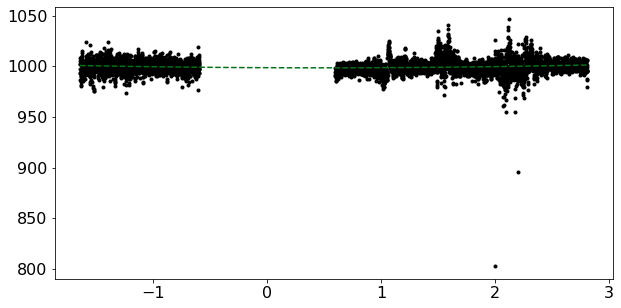

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot((data2_fold*24)[~oot_mask2], data2['flux'][~oot_mask2] - mean, ".k")
plt.plot((data3_fold*24)[~oot_mask3], data3['flux'][~oot_mask3] - mean, ".k")
plt.plot((data4_fold*24)[~oot_mask4], data4['flux'][~oot_mask4] - mean, ".k")
plt.plot((data5_fold*24)[~oot_mask5], data5['flux'][~oot_mask5] - mean, ".k")
x_plot = np.linspace(np.min(x_oot), np.max(x_oot), 1000)
plt.plot(x_plot, pol(x_plot), color="C1", label="model", linestyle="--")
#plt.savefig('ajuste_phot_1199.png',dpi=200,bbox_inches='tight', facecolor='white')

In [ ]:
x_conc = np.concatenate((data2_fold*24, data3_fold*24, data4_fold*24, data5_fold*24), axis=None)
y_conc = np.concatenate(((np.asarray(data2['flux']-mean)/pol(data2_fold*24)-1)*1e3, (np.asarray(data3['flux']-mean)/pol(data3_fold*24)-1)*1e3, 
                        (np.asarray(data4['flux']-mean)/pol(data4_fold*24)-1)*1e3, (np.asarray(data5['flux']-mean)/pol(data5_fold*24)-1)*1e3), axis=None)

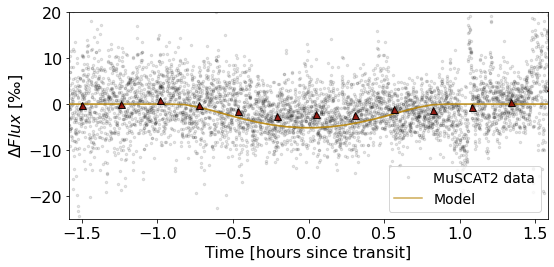

In [ ]:
from scipy import stats
# Plot the folded data
plt.figure(figsize=(8,4))
plt.plot(x_conc, y_conc, '.k', ms=5, label='MuSCAT2 data', zorder=-1000, alpha=0.1)
# Plot the model
pred = np.percentile(flat_samps["lc_pred"], [16, 50, 84], axis=-1)
plt.plot(phase_lc*24, pred[1], color="C4", label="Model", alpha=0.7, zorder=1000)
plt.fill_between(phase_lc*24, pred[0], pred[2], color="C4", alpha=0.5)
# Plot the binned lightcurve
#bins = np.linspace(-0.066*24, 0.116*24, 32)
bins = np.linspace(-0.068*24, 0.0720*24, 14)
denom, _ = np.histogram(x_conc, bins)
num, _ = np.histogram(x_conc, bins, weights=y_conc)
denom[num == 0] = 1.0
binned = stats.binned_statistic(x_conc, y_conc, statistic='std', bins=bins)
binned_count = stats.binned_statistic(x_conc, y_conc, statistic='count', bins=bins)
plt.errorbar((0.5 * (bins[1:] + bins[:-1])), num / denom, yerr=binned.statistic/np.sqrt(binned_count[0]), fmt='^', color='k', 
         ms=7, markeredgecolor='k', markerfacecolor='C2', markeredgewidth=1, alpha=0.9, zorder=1100)
#plt.legend(fontsize=14, loc='best')
plt.legend(fontsize=14, loc=4)
plt.ylabel(u'$\Delta Flux$ [‰]')
plt.xlabel("Time [hours since transit]")
plt.xlim(-0.066*24, 0.066*24)
#plt.xlim(-0.10*24, 0.10*24)
plt.ylim(-25,20)
#plt.savefig('new_phot_1273_muscat2.png',dpi=300,bbox_inches='tight', facecolor='white')
plt.tight_layout()
plt.show()

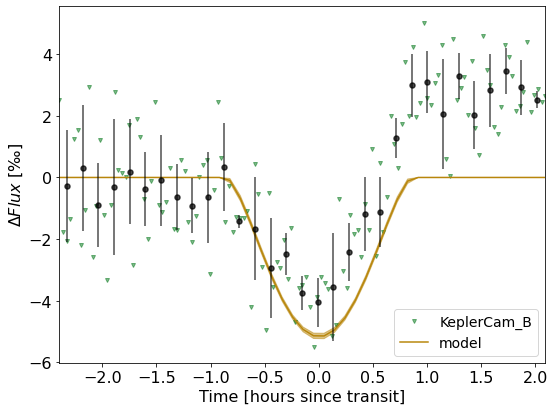

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(data1_fold*24, data1['flux'] - mean-1e3, "v", color='C1', ms=4, label='KeplerCam_B', alpha=0.5)
# Plot the model
pred = np.percentile(flat_samps["lc_pred"], [16, 50, 84], axis=-1)
plt.plot(phase_lc*24, pred[1], color="C4", label="model")
plt.fill_between(phase_lc*24, pred[0], pred[2], color="C4", alpha=0.5)
# Plot the binned lightcurve
bins = np.linspace(-0.10*24, 0.087*24, 32)
denom, _ = np.histogram(data1_fold*24, bins)
num, _ = np.histogram(data1_fold*24, bins, weights=data1['flux'] - mean-1e3)
denom[num == 0] = 1.0
binned = stats.binned_statistic(data1_fold*24, data1['flux']-mean-1e3, statistic='std', bins=bins)
plt.errorbar((0.5 * (bins[1:] + bins[:-1])), num / denom, yerr=binned.statistic, fmt='o', color='k', 
         ms=5, markeredgecolor='k', markeredgewidth=1.5, alpha=0.7, zorder=1000)
plt.legend(fontsize=14, loc=4)
plt.ylabel(u'$\Delta Flux$ [‰]')
plt.xlabel("Time [hours since transit]")
plt.xlim(-0.10*24, 0.087*24)
#plt.ylim(-35,30)
#plt.savefig('new_phot_1273.png',dpi=200,bbox_inches='tight', facecolor='white')
plt.tight_layout()
plt.show()

In [ ]:
# ajustemos un pol grado 2 a los datos oot
# mascaras para sacar los datos en transito
oot_mask1 = bls.transit_mask(data1['time'], p_, bls_duration, t0_)

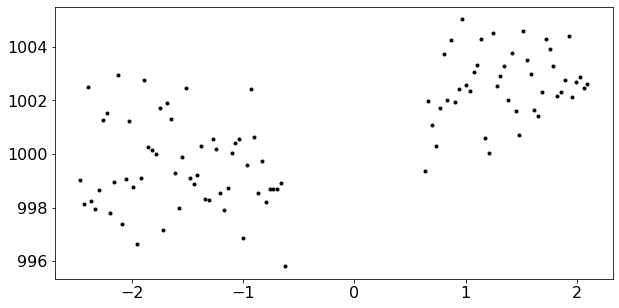

In [ ]:
# checking the oot mask
plt.figure(figsize=(10, 5))
plt.plot((data1_fold*24)[~oot_mask1], data1['flux'][~oot_mask1] - mean, ".k", label="data1", zorder=-1000)

In [ ]:
# fitemos un pol grado 2 a los datos oot
x_oot1 = data1_fold[~oot_mask1]*24
y_oot1 = data1['flux'][~oot_mask1]
# saco los outliers con criterio de 3 sigma
sigmas = 3
index2 = (y_oot1 >= np.mean(y_oot1)-sigmas*np.std(y_oot1)) & (y_oot1 <= np.mean(y_oot1)+sigmas*np.std(y_oot1))
y_oot = y_oot1[index2]
x_oot = x_oot1[index2]
z = np.polyfit(x_oot, y_oot, 2) 
def pol(x):
    return np.asarray(z[0]*x**2 + z[1]*x + z[2])

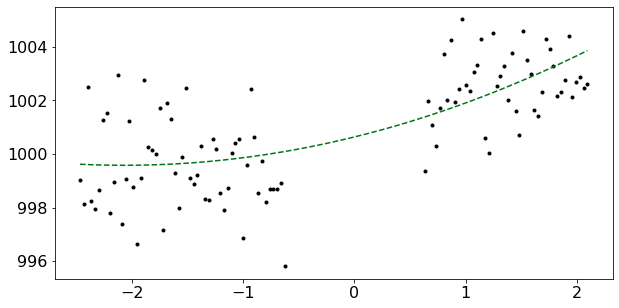

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(x_oot, y_oot - mean, ".k", label="data1", zorder=-1000)
x_plot = np.linspace(np.min(x_oot), np.max(x_oot), 1000)
plt.plot(x_plot, pol(x_plot), color="C1", label="model", linestyle="--")
plt.show()

In [ ]:
y_conc2 = (np.asarray(data1['flux']-mean)/pol(data1_fold*24)-1)*1e3

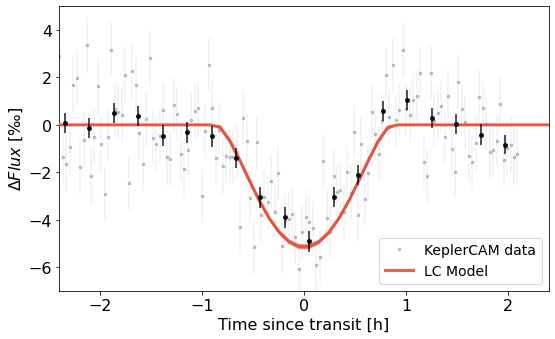

In [ ]:
plt.figure(figsize=(8,5))
# Plot the Keplercam data
plt.plot(data1_fold*24, y_conc2, '.', color='#777777', ms=5, zorder=-1000, label='KeplerCAM data', alpha=0.4)
plt.errorbar(data1_fold*24, y_conc2, yerr=data1['flux_err'], fmt='none', color='#777777', capsize=0, zorder=-1000, alpha=0.1)

# Plot the model
pred = np.percentile(flat_samps["lc_pred"], [16, 50, 84], axis=-1)
plt.plot(phase_lc*24, pred[1], color="#E24A33", label="LC Model", linewidth=3, alpha=0.85, zorder=1000)
plt.fill_between(phase_lc*24, pred[0], pred[2], color="#E24A33", alpha=0.5, zorder=1000)

# Plot the binned lightcurve
lcc = lk.LightCurve(time=data1_fold*24, flux=y_conc2, flux_err=data1['flux_err'])
lcc_binned = lcc.bin(time_bin_size=0.01*24)
plt.errorbar(lcc_binned['time'].value, lcc_binned['flux'].value, yerr=lcc_binned['flux_err'].value,  fmt='o', color='k', 
                 ms=5, markeredgecolor='k', markerfacecolor='k', markeredgewidth=0, alpha=0.9, zorder=1100)
plt.legend(fontsize=14, loc=4)
plt.ylabel(u'$\Delta Flux$ [‰]')
plt.xlabel("Time since transit [h]")
plt.ylim(-7,5)
plt.xlim(-0.10*24, 0.10*24)
plt.tight_layout()
#plt.savefig('new_phot_1273_keplercam.png',dpi=300,bbox_inches='tight', facecolor='white')